## Preliminary study of early-2020 mortality data over Italy

This notebook aims at reproducing the original study by **F. Ricciato (@Eurostat)** published on [CROS portal](https://ec.europa.eu/eurostat/cros/content/preliminary-view-2020-mortality-data-istat) on **April 16th, 2020**.

The study deals with early reports on the beginning of 2020 mortality in Italy and is entitled:

In [1]:
COUNTRY = "IT"
YEAR = 2020
PROVIDER = "ISTAT"
print('"\033[1mA preliminary view at %s mortality data from %s\033[0m"' % (YEAR, PROVIDER))

"A preliminary view at 2020 mortality data from ISTAT"


**_update_** :
* The "original" dataset (referred to as *comune_giorno*) used in the study above (access date: 16/04/20) are no longer referenced (*i.e.*, "visible") on _ISTAT_ main page dedicated to death counts (["Decessi e cause di morte"](https://www.istat.it/it/archivio/240401)). However these data are still available for download ([source](https://www.istat.it/it/files/2020/03/comune-giorno.zip), last access date: 8/05/20)
* The "updated" dataset (referred to as *comuni_giornaliero*) is obviously more complete and contains the last updates ([source](https://www.istat.it/it/files//2020/03/Dataset-decessi-comunali-giornalieri-e-tracciato-record.zip)). It comes together with other aggregated datasets (see webpage above).  
* The current notebook will give you the possibility to (re)run the analysis on any of the datasets above, the updated dataset *comuni_giornaliero* being used by default. The use of the original dataset *comune_giorno* is considered for reproducibility purpose (see this [static version](https://github.com/gjacopo/morbstat/blob/master/docs/notebook_A_preliminary_view_at_2020_mortality_data_from_ISTAT.pdf)). **The selection of the adequate dataset is operated in this [cell](#dataset-choice)**.
* The ingestion of the datasets in the notebook is purely metadata driven. Once a dataset has been chosen, there is no need to change anything. Instead the metadata files provided together with this notebook will contain all the necessary information to process the data (see [metadata/](https://github.com/gjacopo/morbstat/blob/master/metadata) directory). This informs the addition of new fields (for instance, "TIPO_COMUNE") change of naming of some of the columns (for instance, from "TOTALE_20" to "T_20").

**_disclaimer_** :  
* The purpose of this notebook is mostly didactic.
* The data used when running this notebook are fetched  directly fetched from the provider (*ISTAT*) website. While they are always the latest available/updated, they do no necessarily correspond to those used in the original study. 
* The methodological approach adopted here is purely descriptive, it involves no statistical modelling. Note that the methodology is actually not discussed in this notebook, refer to the original publication to this aim. 
* The notebook does not aim at performance either, still it is generic enough to be repurposed for different similar datasets as long as metadata are "descriptive enough".

**Table of Contents**: 
* [Setting and checking the environment first](#Setting)
* [Data ingestion](#Ingestion)
* [Data preparation](#Preparation)
* [Figure 1](#Figure1): Map of ANPR municipalities included in the data set.
* [Figure 2](#Figure2): Daily and cumulated deaths for all municipalities in the data set.
* [Figure 3](#Figure3): Age distribution of total deaths in the period 15-21 March.
* [Figure 4](#Figure4): Relative increment of 2020 over baseline in 15-21 March per age group.
* [Figure 5](#Figure5): Empirical cumulative distribution of excess deaths in 15-21 March 2020 per age group.
* [Figure 6](#Figure6): Daily and cumulated deaths of males aged 65+.
* [Figure 7](#Figure7): Total deaths in the period 1-21 March per individual municipalities.
* [Figures 8-12](#Figure8): Daily and cumulative deaths over individual cities.
* [Figure 13](#Figure13): Total deaths in the week 15-21 March by groups of municipalities within the same province.
* [Figure 14-16](#Figure14): Daily and cumulative deaths over individual provinces.

*note: cells need to be run sequentially!*

Concerning data extraction, while the latest available version of the original study is from April 16th, please note:

In [2]:
from datetime import datetime
print("Last update/running of this notebook: \033[1m%s\033[0m" % datetime.today())

Last update/running of this notebook: 2020-05-08 03:30:23.184480


### Setting and checking the environment first<a id='Setting'></a>

Let's run some setup necessary to import the dependency(ies) required to run the project... First, some generic packages, including a few to handle date/time data since we deal with timeseries:

In [3]:
import os, sys
import json
import time
from datetime import timedelta # and datetime above
import calendar

In the following, we will take care of setting the ready-to-run environment even when libraries/packages are missing. This will ensure you can always run this notebook, in particular on a remote platform (_e.g._, [`binder`](https://mybinder.org), [`Google colab`](https://colab.research.google.com/notebook),...). However, you should probably consider running this notebook in a virtual environment (`conda -n env` or `virtualenv`) so as to make these installs temporary and/or isolated.

Essential for the running of the notebook, besides the basic [`numpy`](https://numpy.org) package, is the [`pandas`](https://pandas.pydata.org) package use for common data handling and processing:

In [4]:
import numpy as np
try:
    import pandas as pd
except ImportError:
    try:
        !{sys.executable} -m pip install pandas
    except:
        raise IOError("!!! Sorry, you're doomed, you won't be able to run this notebook... !!!")
    else:
        print("! Package pandas installed on-the-fly !")

In [5]:
# %%bash # testing google-colab for instance
# [[ ! -e /colabtools ]] && exit
# `which python` -m pip install pandas

Note that the [`geopandas`](https://geopandas.org) package is also used as soon as basic 'geoprocessing' (simple vector data ingestion and map representation) is involved:

In [6]:
try:
    import geopandas as gpd
except ImportError:
    try:
        !{sys.executable} -m pip install geopandas
    except:
        print("! Package geopandas not installed !")
    else:
        print("! Package geopandas installed on-the-fly !")

You will also need to import the [`pyeudatnat`](https://github.com/eurostat/pyEUDatNat) package that contains various useful functions/methods for metadata-based data ingestion: 

In [7]:
try:
    import pyeudatnat
except ImportError:
    try:
        # import google.colab
        !{sys.executable} -m pip install git+https://github.com/eurostat/pyeudatnat.git
        # !{sys.executable} -m pip install pyeudatnat
    except:
        raise IOError("Sorry, you're doomed: package pyeudatnat not installed !")
    else:
        print("! Package pyeudatnat installed on-the-fly !")
else:        
    from pyeudatnat.base import datnatFactory
    from pyeudatnat.io import Frame
    from pyeudatnat.misc import Structure
    from pyeudatnat.misc import Type, Datetime

Last, we will use the [`matplotlib`](https://matplotlib.org) package to render the various illustrations of the original study:

In [8]:
try:
    import matplotlib
except ImportError:
    raise IOError("Guess what: you're doomed...")
else:
    import matplotlib.pyplot as mplt
    import matplotlib.dates as mdates
    from matplotlib.ticker import FuncFormatter, MaxNLocator, IndexLocator
finally:
    _FIGSIZE_, _DPI_ = (7,4), 140 # just some default display size/resolution inside this notebook...
%matplotlib inline

### Data ingestion<a id='Ingestion'></a>

The ingestion of the data is entirely defined through metadata files. Namely, the `JSON` files in the [metadata/](https://github.com/gjacopo/morbstat/blob/master/metadata) directory contains all the information regarding source file location, format, fields, _etc_... is described in these files (see resources listed in the ["Data resources"](https://github.com/eurostat/losstat#Data) section):

In [9]:
DATASET = {'original': 
                {'name':'comune_giorno', 'meta':'ITmetadata-original-comune_giorno.json'},
           'updated': 
                {'name':'comuni_giornaliero', 'meta':'ITmetadata-updated-comuni_giornaliero.json'}
           }

Following, **you can chose here the file you want to analyse:** 
* **'original' to reproduce the results of Ricciato's study,**
* **'updated' to analyse the most recent data.**

**Select the dataset of interest by modifying the value of the variable below:**<a id='dataset-choice'></a>

In [10]:
SELECTION = 'updated'
try:
    assert SELECTION in DATASET.keys()
except:
    raise IOError("You selected a file that is not recognised - must be any value in %s" % list(DATASET.keys()))
else:
    SOURCE, METADATA = DATASET[SELECTION]['name'], DATASET[SELECTION]['meta']
    print("\033[1mThe analysis will be run on the '%s' dataset ('%s'\033[0m)" % (SELECTION,SOURCE))

The analysis will be run on the 'updated' dataset ('comuni_giornaliero')


Proceed by downloading the metadata file. If it does not exist, we download this file from the `github` repository:

In [11]:
THISDIR = !pwd
META = os.path.join(THISDIR[0], 'metadata/%s' % METADATA)
try:
    assert os.path.exists(META)
except:
    !wget -O $META https://raw.githubusercontent.com/gjacopo/morbstat/master/ITmetadata.json
with open(META, 'r') as fp:
    metadata = json.load(fp)
print("Content of the metadata file '%s':\n" % os.path.basename(META))
metadata

Content of the metadata file 'ITmetadata-updated-comuni_giornaliero.json':



{'country': {'code': 'IT', 'name': 'Italia'},
 'lang': {'code': 'it', 'name': 'italian'},
 'file': 'comuni_giornaliero.csv',
 'fmt': 'csv',
 'source': 'https://www.istat.it/it/files//2020/03/Dataset-decessi-comunali-giornalieri-e-tracciato-record.zip',
 'enc': 'latin1',
 'sep': ',',
 'datefmt': '%m%d',
 'index': {'reg_code': {'name': 'REG',
   'desc': 'Codice Istat della Regione di residenza.',
   'type': 'int',
   'values': None},
  'prov_code': {'name': 'PROV',
   'desc': 'Codice Istat della Provincia di residenza.',
   'type': 'int',
   'values': None},
  'region': {'name': 'NOME_REGIONE',
   'desc': 'Regione di residenza.',
   'type': 'str',
   'values': None},
  'province': {'name': 'NOME_PROVINCIA',
   'desc': 'Provincia di residenza.',
   'type': 'str',
   'values': None},
  'city': {'name': 'NOME_COMUNE',
   'desc': 'Comune di residenza.',
   'type': 'str',
   'values': None},
  'city_code': {'name': 'COD_PROVCOM',
   'desc': 'Comune di residenza (classificazione Istat al 01/01

Using the `datnatFactory` method, simply define the data structure:

In [12]:
MortDatIT = datnatFactory(country = "IT")
dIT = MortDatIT(META)
print("Data source: %s - file: \033[94m%s\033[0m" % (dIT.source, dIT.file))
print("Example of data field - number of female deaths in 2016: \033[94m%s\033[0m" % dIT.meta['index']['f_16'])

Data source: https://www.istat.it/it/files//2020/03/Dataset-decessi-comunali-giornalieri-e-tracciato-record.zip - file: comuni_giornaliero.csv
Example of data field - number of female deaths in 2016: {'name': 'F_16', 'desc': 'numero di decessi femminili nel 2016.', 'type': 'int', 'values': None}


Actually, we already define some metadata variables that we will use in the remaining of this notebook (note that this info could be directly inferred when ingesting the data without setting it directly into the metadata file):

In [13]:
FMT = dIT.meta.get('fmt') or dIT.meta.get('file','.').split('.')[1]
ENC = dIT.meta.get('enc',None) 
SEP =  dIT.meta.get('sep',None) 
NAN = dIT.meta.get('nan')
DTYPE = {v['name']: Type.upytname2npt(v['type']) for v in dIT.meta.get('index',{}).values()}
print("Some basic metadata information: \n- field types: \033[94m%s\033[0m \n- format: \033[94m'%s'\033[0m"
      "\n- encoding: \033[94m'%s'\033[0m \n- separator: \033[94m'%s'\033[0m \n- NAN: \033[94m'%s'\033[0m" 
      % (DTYPE,FMT,ENC,SEP,NAN))

Some basic metadata information: 
- field types: {'REG': dtype('int64'), 'PROV': dtype('int64'), 'NOME_REGIONE': dtype('<U'), 'NOME_PROVINCIA': dtype('<U'), 'NOME_COMUNE': dtype('<U'), 'COD_PROVCOM': dtype('<U'), 'TIPO_COMUNE': dtype('int64'), 'CL_ETA': dtype('int64'), 'GE': dtype('<U'), 'M_15': dtype('int64'), 'M_16': dtype('int64'), 'M_17': dtype('int64'), 'M_18': dtype('int64'), 'M_19': dtype('int64'), 'M_20': dtype('int64'), 'F_15': dtype('int64'), 'F_16': dtype('int64'), 'F_17': dtype('int64'), 'F_18': dtype('int64'), 'F_19': dtype('int64'), 'F_20': dtype('int64'), 'T_15': dtype('int64'), 'T_16': dtype('int64'), 'T_17': dtype('int64'), 'T_18': dtype('int64'), 'T_19': dtype('int64'), 'T_20': dtype('int64')} 
- format: 'csv'
- encoding: 'latin1' 
- separator: ',' 
- NAN: 'n.d.'


Let's now retrieve the data *on-the-fly*. Hence everytime you launch this notebook, the original data are collected from *ISTAT* website. The main advantage is that you will always get the newest/latest available data, hence you will be able to update the study. The main drawback is that ... you will use your bandwidth everytime! Note however that the method `load_data` also accepts a `caching` parameter that enable use to load/save the data from/to a cache. Note the purpose of this notebook, check the implementation of the `pyeudatnat` package if interested.

Many ways to actually fetch the data, but we'd rather exploit the meta information available above. However, because of the presence of special characters in the columns (for instance NaN values represented as a string 'n.d' in an integer field), we ensure to download the data are loaded at least without type casting:

In [14]:
try:
    dIT.load_data(fmt = FMT, encoding = ENC, sep = SEP, dtype = DTYPE)
except:
    dIT.load_data(fmt = FMT, encoding = ENC, sep = SEP)
    no_cast = True
else:
    no_cast = False
print ("Data extracted on %s" % Datetime.datetime(Datetime.TODAY(), fmt='%d/%m/%Y'))

Data extracted on 08/05/2020


/Users/gjacopo/Developments/pyEUDatNat/pyeudatnat/io.py:940: UserWarning: 
! 'CSV' data loaded in dataframe !
  warnings.warn("\n! '%s' data loaded in dataframe !" % f.upper())


Let's also simplify the work by broadcasting the dataset into a local variable (not optimal though...):

In [15]:
data = dIT.data     
print("Number of records: \033[1m%s\033[0m - Number of fields (columns): \033[1m%s\033[0m" 
      % data.shape)

Number of records: 914621 - Number of fields (columns): 27


Let's have a first look at the data:

In [16]:
data.head(5)

,REG,PROV,NOME_REGIONE,NOME_PROVINCIA,NOME_COMUNE,COD_PROVCOM,TIPO_COMUNE,CL_ETA,GE,M_15,...,F_17,F_18,F_19,F_20,T_15,T_16,T_17,T_18,T_19,T_20
0,01,001,Piemonte,Torino,Agliè,001001,1,9,0228,0,...,0,0,0,0,0,0,0,0,1,0
1,01,001,Piemonte,Torino,Agliè,001001,1,10,0113,0,...,0,0,0,0,0,0,0,0,1,0
2,01,001,Piemonte,Torino,Agliè,001001,1,11,0305,0,...,0,0,0,0,0,0,0,1,0,0
3,01,001,Piemonte,Torino,Agliè,001001,1,12,0204,0,...,0,0,0,0,0,0,1,0,0,0
4,01,001,Piemonte,Torino,Agliè,001001,1,12,0302,0,...,0,0,0,0,0,0,0,0,0,1


What are the fields? It should be consistent with the `metadata` file we introduced earlier...

In [17]:
print("Fields of the data: \033[94m%s\033[0m" % list(data.columns))  
try:
    assert set(list(data.columns)) == set([v['name'] for v in metadata['index'].values()])
except:
    print("Mismatch between metadata and actual columns in the dataset")

Fields of the data: ['REG', 'PROV', 'NOME_REGIONE', 'NOME_PROVINCIA', 'NOME_COMUNE', 'COD_PROVCOM', 'TIPO_COMUNE', 'CL_ETA', 'GE', 'M_15', 'M_16', 'M_17', 'M_18', 'M_19', 'M_20', 'F_15', 'F_16', 'F_17', 'F_18', 'F_19', 'F_20', 'T_15', 'T_16', 'T_17', 'T_18', 'T_19', 'T_20']


### Data preparation<a id='Preparation'></a>

Let's get rid of those records with no data, _i.e._ with `NAN` values (_e.g._ '9999' for this dataset) in the `T_20` column of total number of deaths in 2020 (_i.e._, data not yet collected):

In [18]:
T_20 = dIT.meta.get('index')['t_20']['name']
print("- field of total deaths in 2020: \033[94m%s\033[0m" % T_20)
print("- value of NAN mask: \033[94m%s\033[0m" % NAN)
data.drop(data.loc[data[T_20]==NAN].index, inplace=True)
print("Number of cleaned records: \033[1m%s\033[0m - Number of fields (unchanged...): \033[1m%s\033[0m" 
      % data.shape)

- field of total deaths in 2020: T_20
- value of NAN mask: n.d.
Number of cleaned records: 666643 - Number of fields (unchanged...): 27


At this stage, after having cleaned the data, we cast all the fields (columns) to the right type, if this has not been done before:

In [19]:
if no_cast is True:
    _type = {t.__name__: t for t in [type, bool, int, float, str, datetime]}
    for v in dIT.meta['index'].values():
        data[v['name']] = Frame.cast(data, v['name'], otype=_type[v['type']]) 

Once the data cleaned, let's have a further look at some basic information, for instance concerning spatial coverage (information regarding province and cities/municipalities for which data have been collected in 2020):

In [20]:
CITY = dIT.meta.get('index')['city']['name']
print("- field of city names: \033[94m%s\033[0m" % CITY)
CITY_CODE = dIT.meta.get('index')['city_code']['name']
print("- field of city codes: \033[94m%s\033[0m" % CITY_CODE)

comuni = data[CITY].unique()
print("\nCities/municipalities in the study: \033[94m%s\033[0m" % comuni)
print("Number of cities/municipalities: \033[1m%s\033[0m" % len(comuni))

- field of city names: NOME_COMUNE
- field of city codes: COD_PROVCOM

Cities/municipalities in the study: ['Agliè' 'Airasca' 'Ala di Stura' ... 'Villasimius' 'Villasor'
 'Villaspeciosa']
Number of cities/municipalities: 6855


or the actual temporal coverage (prior to the year of study):

In [21]:
years = [int("20%s" % tot.split('_')[1]) for tot in data.columns if tot.startswith('%s_' % T_20.split('_')[0])]
ystart, yend =  min(years), max(years)
nyears = len(years)
print('Temporal coverage - Data collections considered: \033[1m[%s, %s]\033[0m' % (ystart, yend))

Temporal coverage - Data collections considered: [2015, 2020]


Let's have a further look at the time series and the dates covered by the collections in the various years:

In [22]:
DAY = dIT.meta.get('index')['date']['name']
print("- field of day: \033[94m%s\033[0m" % DAY)
data[DAY].head(5)

- field of day: GE


0    0228
1    0113
2    0305
3    0204
4    0302
Name: GE, dtype: object

Actually, this is special coding of the days in the form "MonthDay" ("*MeseMeseGiornoGiorno*"), as described in the metadata. We introduce some basic functions to make date format conversions easier in the following:

In [23]:
DATEFMT = dIT.meta.get('datefmt')
print("- date format: \033[94m%s\033[0m" % DATEFMT)
print("The 'day' field %s is described as follow: \033[94m'%s'\033[0m" 
      % (DAY,dIT.meta.get('index')['date']['desc']))

def get_daymonth(ge):
    try:
        ge = datetime.strptime(ge, DATEFMT)
    except ValueError:  # deal with 29/02   
        ge = time.strptime(ge, DATEFMT)
    except TypeError:   pass
    try:
        return ge.day, ge.month
    except:
        return ge.tm_mday, ge.tm_mon
def get_datetime(ge, year):
    d = dict(zip(['d', 'm', 'y'], [*get_daymonth(ge), year]))
    return Datetime.datetime(d, fmt='datetime')

- date format: %m%d
The 'day' field GE is described as follow: 'Giorno di decesso (formato variabile: MeseMeseGiornoGiorno).'


Let's try to understand the purpose of these very basic methods:

In [24]:
today = datetime.today()
print("Today's date is represented in 'datetime' format as: %s" % today)
today_ge = '%02d%02d' % (today.month, today.day) # or also: datetime.strftime(today, DATEFMT) 
print("If today's date was present in the IT dataset, it would be represented in the \033[1m%s\033[0m field as: \033[1m'%s'\033[0m" 
      % (DAY,today_ge))
print("\nWhat 'get_daymonth' does, is simply return the '(day,month)' formatted date, whatever the input format:")
print("- given today=%s, get_daymonth(today) returns %s" % (today,get_daymonth(today)))
print("- given today='%s', get_daymonth(today) returns %s" % (today_ge,get_daymonth(today)))
print("\nThen 'get_datetime' retrieves the matching '(day,month)' of a given date in any other year:")
print("- given today=%s, get_datetime(today,2019) returns %s" % (today,get_datetime(today,2005)))
print("- given today='%s', get_datetime(today, 1912) returns also %s" % (today_ge,get_datetime(today,1912)))
print("Note in particular for the leap day:")
print("- get_datetime('0229',2000) returns %s" % get_datetime('0229',2000))
try:
    print("- get_datetime('0229',2019) returns %s" % get_datetime('0229',2019))
except ValueError:
    print("- get_datetime('0229',2019) fails as we could expect...")

Today's date is represented in 'datetime' format as: 2020-05-08 03:31:39.211287
If today's date was present in the IT dataset, it would be represented in the GE field as: '0508'

What 'get_daymonth' does, is simply return the '(day,month)' formatted date, whatever the input format:
- given today=2020-05-08 03:31:39.211287, get_daymonth(today) returns (8, 5)
- given today='0508', get_daymonth(today) returns (8, 5)

Then 'get_datetime' retrieves the matching '(day,month)' of a given date in any other year:
- given today=2020-05-08 03:31:39.211287, get_datetime(today,2019) returns 2005-05-08 00:00:00
- given today='0508', get_datetime(today, 1912) returns also 1912-05-08 00:00:00
Note in particular for the leap day:
- get_datetime('0229',2000) returns 2000-02-29 00:00:00
- get_datetime('0229',2019) fails as we could expect...


Given the `DAY` (*i.e.*, "GE") column, we can find out about the first and last days represented in the study:

In [25]:
dstart, dend = data[DAY].min(), data[DAY].max()
print('Period of data collection considered: \033[1m[%s/%s, %s/%s]\033[0m' % \
      (*get_daymonth(dstart), *get_daymonth(dend)))

Period of data collection considered: [1/1, 15/4]


Considering the temporal corevage (over >4 years), we introduce a year of reference to define the (maximal) length of the time series:

In [26]:
YREF = 2000 
print("A leap year for sure: %s!" % YREF)
dstartref, dendref = get_datetime(dstart, YREF), get_datetime(dend, YREF)

span = Datetime.span(since=dstartref, until=dendref)
ndays = span.days + 1 # +1 because dates are inclusive
print('Max lenght of the time series, i.e. number of days covered by the data collection: \033[1m%s days\033[0m' 
      % ndays)

A leap year for sure: 2000!
Max lenght of the time series, i.e. number of days covered by the data collection: 106 days


One more consideration regarding the presence of a leapday in the time-series:

In [27]:
leapday = Datetime.datetime({'y':YREF, 'm':2, 'd':29}, fmt='datetime')
spanleap = Datetime.span(since=dstartref, until=leapday)
ileapday = spanleap.days # note that indexing starts at 0
print('Time series will be padded in position: \033[1m%s\033[0m corresponding to leapday 29/02' % ileapday)

Time series will be padded in position: 59 corresponding to leapday 29/02


We also introduce, for the rest of the study, an timeline index based on the longest possible time series (for instance during the `YREF` leap year):

In [28]:
idx_timeline = pd.date_range(start=dstartref, end=dendref, freq=timedelta(1))
assert len(idx_timeline) == ndays
print(idx_timeline)

DatetimeIndex(['2000-01-01', '2000-01-02', '2000-01-03', '2000-01-04',
               '2000-01-05', '2000-01-06', '2000-01-07', '2000-01-08',
               '2000-01-09', '2000-01-10',
               ...
               '2000-04-06', '2000-04-07', '2000-04-08', '2000-04-09',
               '2000-04-10', '2000-04-11', '2000-04-12', '2000-04-13',
               '2000-04-14', '2000-04-15'],
              dtype='datetime64[ns]', length=106, freq='D')


### Figure 1 - Map of ANPR municipalities included in the data set<a id='Figure1'></a>

Similarly to the mortality dataset, the geographical dataset that will help us identify (and locate) cities/municipalities in the dataset is represented by a metadata info file, namely the `JSON` file 'ITmetadata.json' that should be contained in this directory:

In [29]:
GEOMETA = os.path.join(THISDIR[0], 'metadata/ITmetageo.json')
try:
    assert os.path.exists(GEOMETA)
except:
    !wget -O $GEOMETA https://raw.githubusercontent.com/gjacopo/morbstat/master/ITmetageo.json
dgeoIT = MortDatIT(GEOMETA)

Note the location and format (shapefile files in a remote zip file) of the source datasets:

In [30]:
print("Source file: %s" % dgeoIT.meta.source)
print("Datasets: \033[94m'%s'\033[0m" % dgeoIT.meta.file)

Source file: http://www.istat.it/storage/cartografia/confini_amministrativi/non_generalizzati/Limiti01012020.zip
Datasets: '['Com01012020_WGS84.shp', 'Com01012020_WGS84.shx', 'Com01012020_WGS84.dbf', 'Com01012020_WGS84.prj']'


We will load the geographical data using that same `load_data` method as earlier. Because of the way it is implemented (the package `pyeudatnat` uses `geopandas` for the representation and handling of geographical/vector datasets), the data will need to be loaded on the disk (hence the option `on_disk=True` below). In addition, because the format of the data is known (shapefile), we ensure only this file is loaded (the option `infer_fmt=False` will prevent from trying to load all the other files ['.shx', '.dbf', '.prj'] that normaly accompany the shapefile '.shp'). You could also add the keyword option `fmt='shapefile'` below:  

In [31]:
dgeoIT.load_data(on_disk=True, infer_fmt=False)
print ('Geo information retrieved on \033[1m%s\033[0m' % Datetime.datetime(Datetime.TODAY(), fmt='%d/%m/%Y'))

Geo information retrieved on 08/05/2020


/Users/gjacopo/Developments/pyEUDatNat/pyeudatnat/io.py:940: UserWarning: 
! 'SHP' data loaded in dataframe !
  warnings.warn("\n! '%s' data loaded in dataframe !" % f.upper())
/Users/gjacopo/Developments/pyEUDatNat/pyeudatnat/io.py:1087: UserWarning: 
! File 'Limiti01012020/Com01012020/Com01012020_WGS84.shx' will not be loaded !
  warnings.warn("\n! File '%s' will not be loaded !" % file)
/Users/gjacopo/Developments/pyEUDatNat/pyeudatnat/io.py:1087: UserWarning: 
! File 'Limiti01012020/Com01012020/Com01012020_WGS84.dbf' will not be loaded !
  warnings.warn("\n! File '%s' will not be loaded !" % file)
/Users/gjacopo/Developments/pyEUDatNat/pyeudatnat/io.py:1087: UserWarning: 
! File 'Limiti01012020/Com01012020/Com01012020_WGS84.prj' will not be loaded !
  warnings.warn("\n! File '%s' will not be loaded !" % file)


We can check the projection used for representing the data. In that case ('WGS84' or 'EPSG:32632' code), data are simply represented by their geographical (latitute/longitude) coordinates:

In [32]:
print(dgeoIT.data.crs)
dgeoIT.data.crs

epsg:32632


<Projected CRS: EPSG:32632>
Name: WGS 84 / UTM zone 32N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World - N hemisphere - 6°E to 12°E - by country
- bounds: (6.0, 0.0, 12.0, 84.0)
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [33]:
print('Attributes of the geodata (including geometries): \033[94m%s\033[0m' % list(dgeoIT.data.columns))  
dgeoIT.data.head(5)

Attributes of the geodata (including geometries): ['COD_RIP', 'COD_REG', 'COD_PROV', 'COD_CM', 'COD_UTS', 'PRO_COM', 'PRO_COM_T', 'COMUNE', 'COMUNE_A', 'CC_UTS', 'SHAPE_LENG', 'SHAPE_AREA', 'SHAPE_LEN', 'geometry']


,COD_RIP,COD_REG,COD_PROV,COD_CM,COD_UTS,PRO_COM,PRO_COM_T,COMUNE,COMUNE_A,CC_UTS,SHAPE_LENG,SHAPE_AREA,SHAPE_LEN,geometry
0,1,1,1,201,201,1077,001077,Chiaverano,None,0,18164.369945,1.202212e+07,18164.236621,"POLYGON ((414358.390 5042001.044, 414381.796 5..."
1,1,1,1,201,201,1079,001079,Chiesanuova,None,0,10777.398475,4.118911e+06,10777.318814,"POLYGON ((394621.039 5031581.116, 394716.100 5..."
2,1,1,1,201,201,1089,001089,Coazze,None,0,41591.434852,5.657268e+07,41591.122092,"POLYGON ((364914.897 4993224.894, 364929.991 4..."
3,1,1,1,201,201,1006,001006,Almese,None,0,17058.567837,1.787564e+07,17058.439037,"POLYGON ((376934.962 4999073.854, 376960.555 4..."
4,1,1,1,201,201,1007,001007,Alpette,None,0,9795.635259,5.626076e+06,9795.562269,"POLYGON ((388890.737 5030465.123, 388945.987 5..."


In particular, the geographical (vector) information is specifically provided through the `geometry` field of the dataset as a set of `shapely` structures: 

In [34]:
dgeoIT.data['geometry'].head(5)

0    POLYGON ((414358.390 5042001.044, 414381.796 5...
1    POLYGON ((394621.039 5031581.116, 394716.100 5...
2    POLYGON ((364914.897 4993224.894, 364929.991 4...
3    POLYGON ((376934.962 4999073.854, 376960.555 4...
4    POLYGON ((388890.737 5030465.123, 388945.987 5...
Name: geometry, dtype: geometry

We will 'join' the information from both datasets by matching the field/attribute that represent the city code in the two datasets: 

In [35]:
CITY_CODE = dIT.meta.get('index')['city_code']['name'] 
print("- field uniquely identifying cities/municipalities in mortality dataset: \033[94m%s\033[0m" % CITY_CODE)
PRO_COM_T = dgeoIT.meta.get('index')['PRO_COM_T']['name'] 
print("- field uniquely identifying cities/municipalities in geographical reference dataset: \033[94m%s\033[0m" % PRO_COM_T)
code_comuni = Structure.uniq_list(data[CITY_CODE].to_list())
# assert len(code_comuni) == len(comuni) # some inconsistencies in the datasets...

- field uniquely identifying cities/municipalities in mortality dataset: COD_PROVCOM
- field uniquely identifying cities/municipalities in geographical reference dataset: PRO_COM_T


Note that the 'join' operation is not an actual 'join', instead we filter out the geographical datasets to keep only those cities/municipalities that are also present in the mortality dataset:

In [36]:
geodata = dgeoIT.data[dgeoIT.data.set_index(PRO_COM_T).index.isin(code_comuni)]
geodata.head(5)

,COD_RIP,COD_REG,COD_PROV,COD_CM,COD_UTS,PRO_COM,PRO_COM_T,COMUNE,COMUNE_A,CC_UTS,SHAPE_LENG,SHAPE_AREA,SHAPE_LEN,geometry
0,1,1,1,201,201,1077,001077,Chiaverano,None,0,18164.369945,1.202212e+07,18164.236621,"POLYGON ((414358.390 5042001.044, 414381.796 5..."
1,1,1,1,201,201,1079,001079,Chiesanuova,None,0,10777.398475,4.118911e+06,10777.318814,"POLYGON ((394621.039 5031581.116, 394716.100 5..."
2,1,1,1,201,201,1089,001089,Coazze,None,0,41591.434852,5.657268e+07,41591.122092,"POLYGON ((364914.897 4993224.894, 364929.991 4..."
3,1,1,1,201,201,1006,001006,Almese,None,0,17058.567837,1.787564e+07,17058.439037,"POLYGON ((376934.962 4999073.854, 376960.555 4..."
4,1,1,1,201,201,1007,001007,Alpette,None,0,9795.635259,5.626076e+06,9795.562269,"POLYGON ((388890.737 5030465.123, 388945.987 5..."


We simply map the remaining geometries (that exclusively correspond to cities present in the mortality dataset) to get a visual hint on the representativeness of the samples in the dataset (samples mostly concentrated around the Lombardia region):

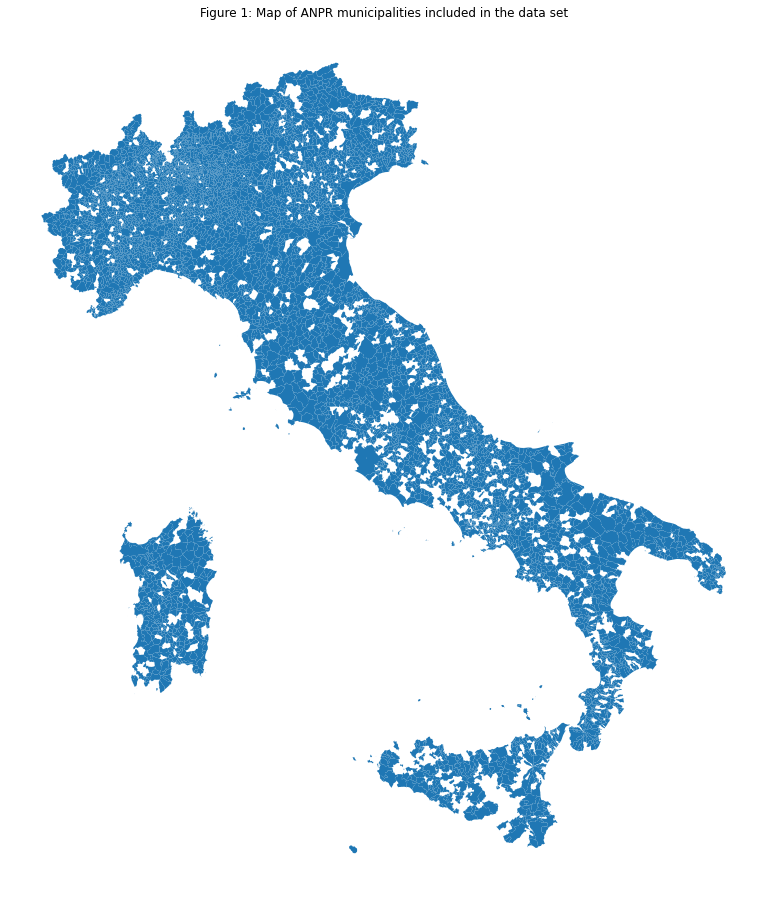

In [37]:
f, ax = mplt.subplots(1, figsize=(16, 16))
geodata.plot(ax=ax)
ax.set_axis_off()
ax.set_title('Figure 1: Map of ANPR municipalities included in the data set')
mplt.show()

### Figure 2 - Daily and cumulated deaths for all municipalities in the data set<a id='Figure2'></a>

We now represent the daily and cumulated deaths for the entire population and for all municipalities present in the dataset.

Simply group by date and sum the total counts of deaths per year ("TOTAL_\*\*") over all other remaining fields (*e.g.*, age class and cities):

In [38]:
dailydeaths = pd.DataFrame()
for y in years:
    TCOL = dIT.meta.get('index')['t_%s' % str(y)[2:]]['name'] 
    dailydeaths[y] = data.groupby(DAY)[TCOL].agg('sum')
dailydeaths.head(5)

,2015,2016,2017,2018,2019,2020
GE,,,,,,
0101,2253,1748,2187,2014,1742,1685
0102,1895,1665,2295,2022,1784,1690
0103,1900,1639,2317,1965,1755,1706
0104,1951,1725,2260,1973,1666,1692
0105,2003,1720,2252,2037,1732,1671


We also possibly pad the data for non-leap years on the date 29/02:

In [39]:
print("Counts on 29/02 \033[1mbefore\033[0m padding:\n %s" % dailydeaths.iloc[ileapday-1:ileapday+1,:])
for y in years:
    if calendar.isleap(y): continue
    yloc = dailydeaths.columns.get_loc(y)
    dailydeaths.iloc[ileapday,yloc] = dailydeaths.iloc[ileapday-1,yloc]
print("Counts on 29/02 \033[1mafter\033[0m padding:\n %s" % dailydeaths.iloc[ileapday-1:ileapday+1,:])

Counts on 29/02 before padding:
       2015  2016  2017  2018  2019  2020
GE                                      
0228  1689  1509  1700  1753  1834  1671
0229     0  1504     0     0     0  1594
Counts on 29/02 after padding:
       2015  2016  2017  2018  2019  2020
GE                                      
0228  1689  1509  1700  1753  1834  1671
0229  1689  1504  1700  1753  1834  1594


Note that at this stage, the table is indexed by the `DAY` (*i.e.*, 'GE') field (in the form *'MeseMeseGiornoGiorno'*). Instead we want to set the index to the known dates and reindex with the actual timeline since days may be missing (?):

In [40]:
print('Initial index: %s' % dailydeaths.index)       
dailydeaths.set_index(dailydeaths.index.to_series().apply(lambda ge: get_datetime(ge,YREF)), inplace=True)
dailydeaths = dailydeaths.reindex(idx_timeline, fill_value=0)       
# instead of dailydeaths.set_index(idx_rng, inplace=True)
print('Index reset to actual timeline an garanteed complete days: %s' % dailydeaths.index)       

Initial index: Index(['0101', '0102', '0103', '0104', '0105', '0106', '0107', '0108', '0109',
       '0110',
       ...
       '0406', '0407', '0408', '0409', '0410', '0411', '0412', '0413', '0414',
       '0415'],
      dtype='object', name='GE', length=106)
Index reset to actual timeline an garanteed complete days: DatetimeIndex(['2000-01-01', '2000-01-02', '2000-01-03', '2000-01-04',
               '2000-01-05', '2000-01-06', '2000-01-07', '2000-01-08',
               '2000-01-09', '2000-01-10',
               ...
               '2000-04-06', '2000-04-07', '2000-04-08', '2000-04-09',
               '2000-04-10', '2000-04-11', '2000-04-12', '2000-04-13',
               '2000-04-14', '2000-04-15'],
              dtype='datetime64[ns]', length=106, freq='D')


We introduce two additional time-series for comparison, the count of deaths averaged over all the years prior to the year of study (`years_exc`): 

In [41]:
years_exc = years.copy()
years_exc.remove(YEAR)

avdailydeathsexc = dailydeaths[years_exc].mean(axis = 1, skipna =True) 
avdailydeathsexc

2000-01-01    1988.8
2000-01-02    1932.2
2000-01-03    1915.2
2000-01-04    1915.0
2000-01-05    1948.8
               ...  
2000-04-11     999.6
2000-04-12    1007.0
2000-04-13    1026.8
2000-04-14    1014.2
2000-04-15    1015.0
Freq: D, Length: 106, dtype: float64

and the average count of deaths by week:

In [42]:
weeklydeaths = dailydeaths.resample('W').mean()
weeklydeaths.head(5)

,2015,2016,2017,2018,2019,2020
2000-01-02,2074.000000,1706.500000,2241.000000,2018.000000,1763.000000,1687.500000
2000-01-09,1938.285714,1677.428571,2219.285714,1999.428571,1765.571429,1710.142857
2000-01-16,1918.000000,1622.428571,2346.714286,1936.857143,1855.142857,1718.285714
2000-01-23,1850.142857,1637.714286,2186.285714,1866.428571,1883.428571,1726.000000
2000-01-30,1850.000000,1646.285714,1997.714286,1796.714286,1891.857143,1717.000000


For displaying the data (likewise the figures in the original publication), we introduce our own 'house-made' plotting function to further simplifying the automated display of time-series:

In [43]:
def plot_one(dat, index = None, one = None, bar=False, 
             fig=None, ax=None, figsize=_FIGSIZE_, dpi=_DPI_, shp = (1,1), 
             marker='v', color='r', linestyle='-', label='',  
             grid = False, xticks = None, xticklabels = None, xrottick = False, 
             locator = None, formatter = None, 
             xlabel='', ylabel='', title = '', suptitle=''): 
    if ax is None:
        if shp in (None,[],()): shp = (1,1)
        if dpi is None:     
            fig, pax = mplt.subplots(*shp, figsize=figsize, constrained_layout=True)
        else:               
            fig, pax = mplt.subplots(*shp, figsize=figsize, dpi=dpi, constrained_layout=True)
        if isinstance(pax,np.ndarray):
            if pax.ndim == 1:    ax_ = pax[0]
            else:               ax_ = pax[0,0]
        else:
            ax_ = pax
    else:
        ax_, pax = ax, None
    if index is None:
        index = dat.index
    if bar is True:
        ax_.bar(dat.index.values, 
                dat.loc[index] if one is None else dat.loc[index, one], 
                color=color, label=label)
    else:
        ax_.plot(dat.loc[index] if one is None else dat.loc[index, one], 
                 c=color, marker=marker, markersize=3, ls=linestyle, lw=0.6,
                 label=label)
    ax_.set_xlabel(xlabel), ax_.set_ylabel(ylabel)
    if grid is not False:       ax_.grid(linewidth=grid)
    if xticks is not None:      ax_.set_xticks(xticks)
    if xticklabels is not None: ax_.set_xticklabels(xticklabels)            
    if xrottick is not False:   ax_.tick_params(axis ='x', labelrotation=xrottick)
    if formatter is not None:   ax_.xaxis.set_major_formatter(formatter)
    if locator is not None:     ax_.xaxis.set_major_locator(locator)
    ax_.legend(fontsize='small')
    if title not in ('',None):  ax_.set_title(title,  fontsize='medium')
    if fig is not None and suptitle not in ('',None):       
        fig.suptitle(suptitle,  fontsize='medium')
    if pax is not None:
        return fig, pax

Let's see quickly how this works in practice on a dummy example: 

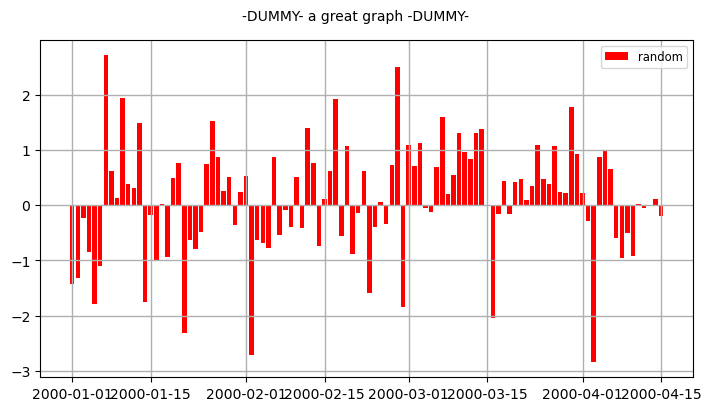

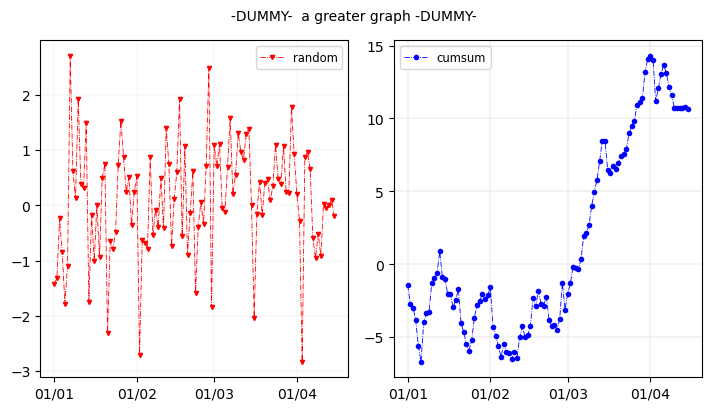

In [44]:
ts = pd.Series(np.random.randn(ndays), index=idx_timeline)
plot_one(ts,index=slice(dstartref,dendref), bar=True, label='random', dpi=100, grid = 1,
         suptitle='-DUMMY- a great graph -DUMMY-'
        )

tsc = ts.cumsum()
locator = mdates.DayLocator(bymonthday=1) 
formatter = mdates.DateFormatter('%d/%m')
fig, ax = plot_one(ts, index=slice(dstartref,dendref), label='random', shp=(1,2), 
                   linestyle='-.', grid = 0.1,
                   dpi=100, locator = locator, formatter = formatter
                  )
plot_one(tsc, index=slice(dstartref,dendref), label='cumsum', fig=fig, ax=ax[1], 
         grid = 0.2, linestyle='dashdot', color='b', marker = 'o', 
         suptitle='-DUMMY-  a greater graph -DUMMY- ', 
         locator = locator, formatter = formatter
        )

Now, we can use it to plot the 3 created series all together to get a first 'flavour' of the temporal evolution:

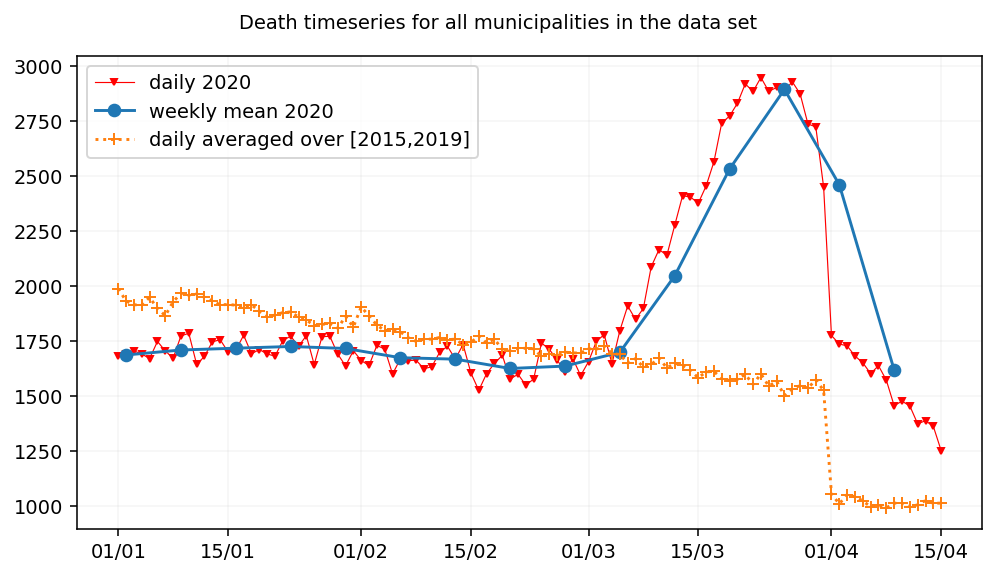

In [45]:
locator = mdates.DayLocator(bymonthday=[1,15]) 
formatter = mdates.DateFormatter('%d/%m')

fig, ax = plot_one(dailydeaths, one = YEAR, index=slice(dstartref,dendref), label='daily %s' % YEAR,  
                   suptitle = 'Death timeseries for all municipalities in the data set', grid = 0.1,
                   locator = locator, formatter = formatter
                  )

ax.plot(weeklydeaths.loc[dstartref:dendref, YEAR],
        marker='o', markersize=6, linestyle='-', label='weekly mean %s' % YEAR
       )

ax.plot(avdailydeathsexc.loc[dstartref:dendref],
        marker='+', linestyle=':',
        label='daily averaged over [%s,%s]' % (min(years_exc),max(years_exc))
       )

ax.legend()

We introduce another "house-made" plotting method:

In [46]:
def plot_oneversus(dat, index = None, one = None, versus = None,  
                   fig=None, ax=None, shp = (1,1), dpi=_DPI_,
                   xlabel='', ylabel='', title = '', xrottick = False, legend = None,                 
                   grid = False, suptitle = '', locator = None, formatter = None):    
    if ax is None:
        if shp in (None,[],()): shp = (1,1)
        if dpi is None:     fig, pax = mplt.subplots(*shp, constrained_layout=True)
        else:               fig, pax = mplt.subplots(*shp, dpi=dpi, constrained_layout=True)
        if isinstance(pax,np.ndarray):
            if pax.ndim == 1:    ax_ = pax[0]
            else:               ax_ = pax[0,0]
        else:
            ax_ = pax
    else:
        ax_, pax = ax, None
    if index is None:
        index = dat.index
    if one is not None:
        ax_.plot(dat.loc[index,one], ls='-', lw=0.6, c='r', 
                 marker='v', markersize=6, fillstyle='none')
        next(ax_._get_lines.prop_cycler)
    if versus is None:
        versus = dat.columns
        try:    versus.remote(one)
        except: pass
    ax_.plot(dat.loc[index,versus], ls='None', marker='o', fillstyle='none')
    ax_.set_xlabel(xlabel), ax_.set_ylabel(ylabel)
    if grid is not False:       ax_.grid(linewidth=grid)
    if xrottick is not False:   ax_.tick_params(axis ='x', labelrotation=xrottick)
    if locator is not None:     ax_.xaxis.set_major_locator(locator)
    if formatter is not None:   ax_.xaxis.set_major_formatter(formatter)
    if legend is None:
        legend = [one]
        legend.extend(versus)
    ax_.legend(legend, fontsize='small')
    if title not in ('',None):  ax_.set_title(title,  fontsize='medium')
    if suptitle not in ('',None):       
        fig.suptitle(suptitle,  fontsize='medium')
    if pax is not None:
        return fig, pax

Again, let's see quickly how this works in practice on a dummy example: 

(<Figure size 600x400 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x118220f10>)

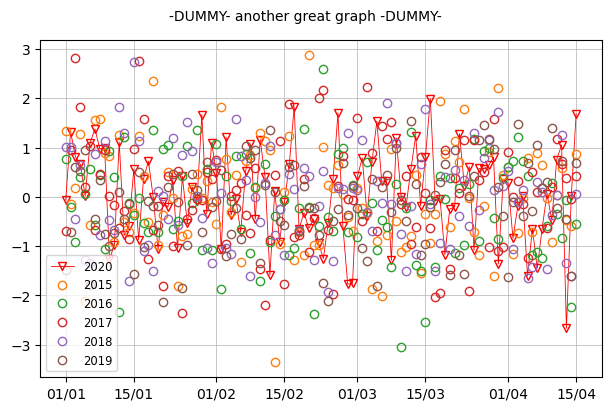

In [47]:
ts = pd.DataFrame(np.random.randn(ndays, nyears), index=idx_timeline, columns=years)
plot_oneversus(ts,index=slice(dstartref,dendref), one=YEAR, versus=years_exc, dpi=100, grid = 0.5,
               suptitle='-DUMMY- another great graph -DUMMY-', 
               locator = locator, formatter = formatter
              )

and let's use it to represent the temporal evolution of the different time series for the available years:

(<Figure size 840x560 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x118275050>)

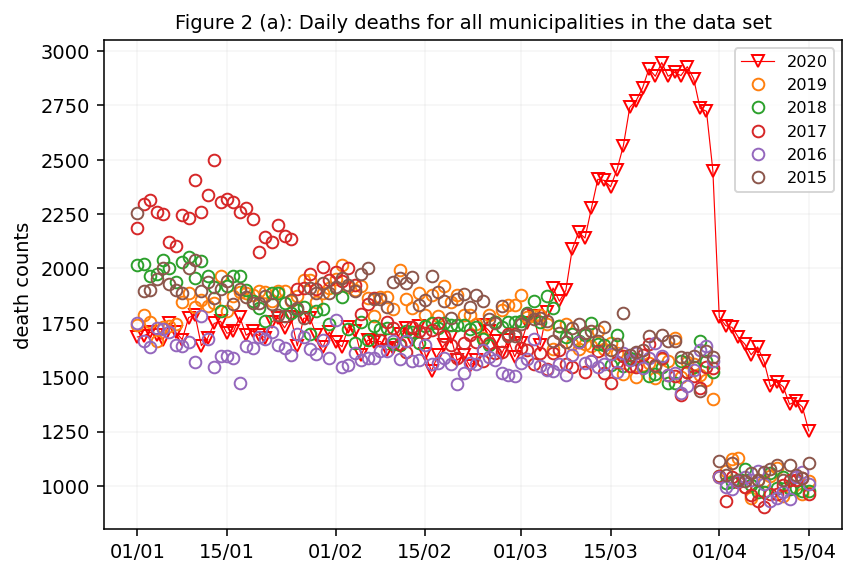

In [48]:
plot_oneversus(dailydeaths, one = YEAR, versus = years_exc[::-1], grid = 0.1,
               ylabel='death counts', title = 'Figure 2 (a): Daily deaths for all municipalities in the data set', 
               locator = locator, formatter = formatter
              )

Following, we also create the timeseries of cumulated counts:

In [49]:
cumdailydeaths = dailydeaths.cumsum(axis = 0)
cumdailydeaths.head(5)

,2015,2016,2017,2018,2019,2020
2000-01-01,2253,1748,2187,2014,1742,1685
2000-01-02,4148,3413,4482,4036,3526,3375
2000-01-03,6048,5052,6799,6001,5281,5081
2000-01-04,7999,6777,9059,7974,6947,6773
2000-01-05,10002,8497,11311,10011,8679,8444


and display it:

(<Figure size 840x560 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x118245750>)

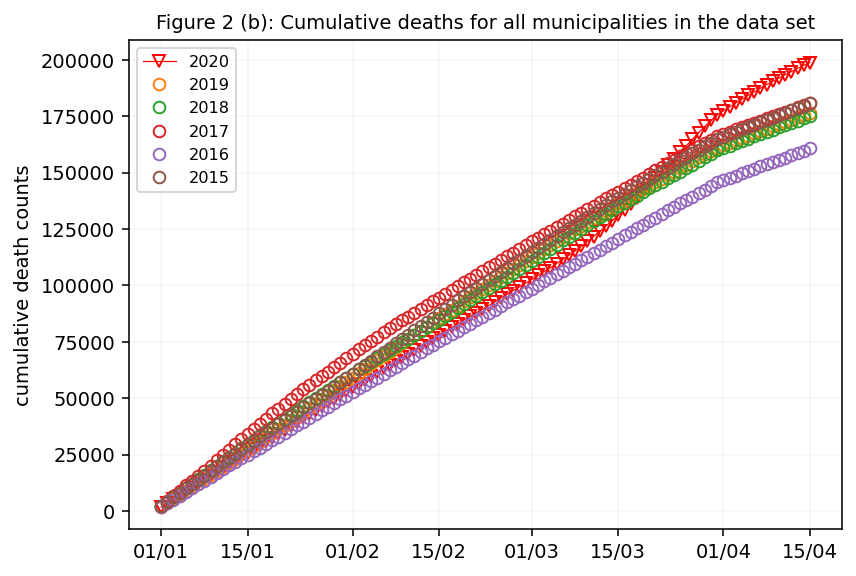

In [50]:
plot_oneversus(cumdailydeaths, one = YEAR, versus = years_exc[::-1], grid = 0.1,
               ylabel='cumulative death counts', 
               title = 'Figure 2 (b): Cumulative deaths for all municipalities in the data set', 
               locator = locator, formatter = formatter
              )

### Figure 3 - Age distribution of total deaths in the period 15-21 March<a id='Figure3'></a>

First we set the period of interest:

In [51]:
dstart = get_datetime('0315',YREF)   
week = dstart.isocalendar()[1]
dend = dstart + timedelta(6) # ddays[-1] 
ddays = ['%02d%02d' % (d.month,d.day) for d in [dstart + timedelta(i) for i in range(6)]]

We will use the specific field with class ages in the dataset. That's also where the metadata information comes handy:

In [52]:
AGE = dIT.meta.get('index')['age']['name']
print("- field of age classes: \033[94m%s\033[0m" % AGE)
FORMATTER = dIT.meta.get('index')['age']['values']
print("- range of age classes: \033[94m%s\033[0m" % FORMATTER)

- field of age classes: CL_ETA
- range of age classes: {'0': '0', '1': '1-4', '2': '5-9', '3': '10-14', '4': '15-19', '5': '20-24', '6': '25-29', '7': '30-34', '8': '35-39', '9': '40-44', '10': '45-49', '11': '50-54', '12': '55-59', '13': '60-64', '14': '65-69', '15': '70-74', '16': '75-79', '17': '80-84', '18': '85-89', '19': '90-94', '20': '95-99', '21': '100+'}


For this illustration, we will create a dictionary of dataframes indexed by gender: 't', 'f' and 'm'. We then proceed like for the previous dataset `dailydeaths`, simply grouping by date and age class, then *resp.* summing the 't', 'f' and 'm' counts of deaths per year (*resp.*, "TOTAL_\*\*", "F_\*\*" and "M_\*\*") over all other remaining fields (*e.g.*, cities): 

In [53]:
ageofdeaths = dict.fromkeys(['t','f','m'])
for k in ageofdeaths.keys():
    deaths = pd.DataFrame()
    for y in years:
        COL = dIT.meta.get('index')['%s_%s' % (k,str(y)[2:])]['name']
        d = data.groupby([AGE,DAY])[COL].agg('sum')
        if leapday >= dstart and leapday <= dend:
            # well... we should do something to be truly generic here... next time!
            pass
        deaths[y] = d[d.index.get_level_values(DAY).isin(ddays)].groupby(AGE).agg('sum')
    ageofdeaths.update({k: deaths})
ageofdeaths['f'].head(5)

,2015,2016,2017,2018,2019,2020
CL_ETA,,,,,,
0,4,13,8,7,9,6
1,2,1,4,2,1,1
2,1,0,0,3,0,0
3,0,1,2,2,0,0
4,1,0,2,4,4,2


We then represent together the series for the different years:

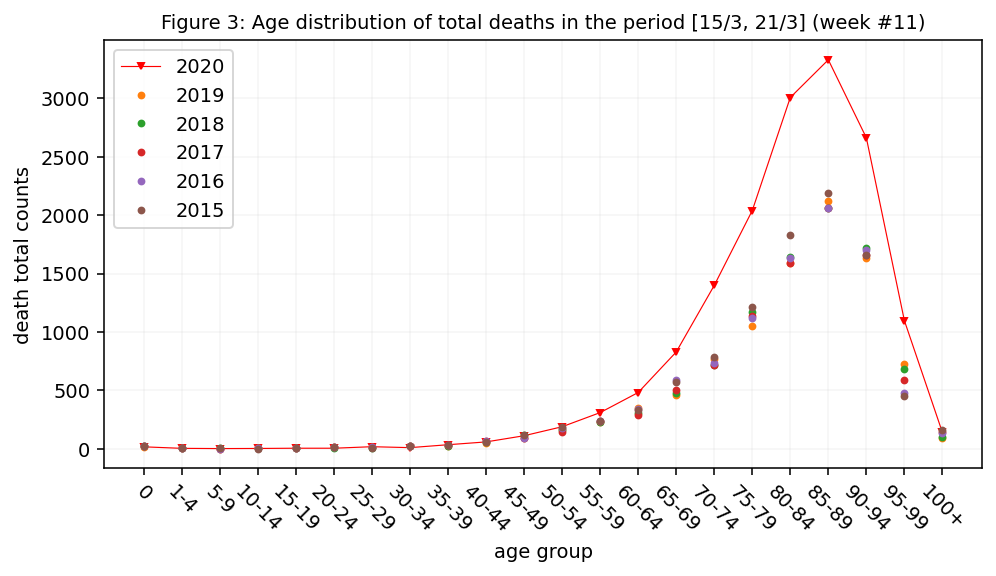

In [54]:
fig, ax = plot_one(ageofdeaths['t'], one = YEAR, label = YEAR,
                   marker = 'v', color = 'r', linestyle = '-', xrottick = -45, grid = 0.1,
                   xlabel = 'age group', ylabel = 'death total counts',
                   title = 'Figure 3: Age distribution of total deaths in the period [%s/%s, %s/%s] (week #%s)' %
                       (*get_daymonth(dstart), *get_daymonth(dend), week),
                   xticks = list(range(len(FORMATTER.keys()))), xticklabels = list(FORMATTER.values())
                  )

next(ax._get_lines.prop_cycler)
ax.plot(ageofdeaths['t'][years_exc[::-1]],
        marker='o', markersize=3, linestyle='None'
       )

ax.legend(years[::-1]) 

### Figure 4 - Relative increment of 2020 over baseline in 15-21 March per age group<a id='Figure4'></a>

The previously generated dataset `ageofdeaths` is used to relative increment of 2020 over baseline in 15-21 March per age group:

In [55]:
for k in ageofdeaths.keys():
    deaths = ageofdeaths[k]
    deaths['base'] = deaths[years_exc].mean(axis = 1)
    deaths['rinc'] = deaths[YEAR].sub(deaths.base).div(deaths.base)

We define the period of interest:

In [56]:
astart, aend = 11, max(map(int,list(FORMATTER.keys())))
rages, sages = range(astart, aend+1), slice(astart, aend)
print("Age ranges considered in '65+': \033[1m%s\033[0m" % [FORMATTER[str(i)] for i in rages])

Age ranges considered in '65+': ['50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89', '90-94', '95-99', '100+']


that we use then for generating the figure:

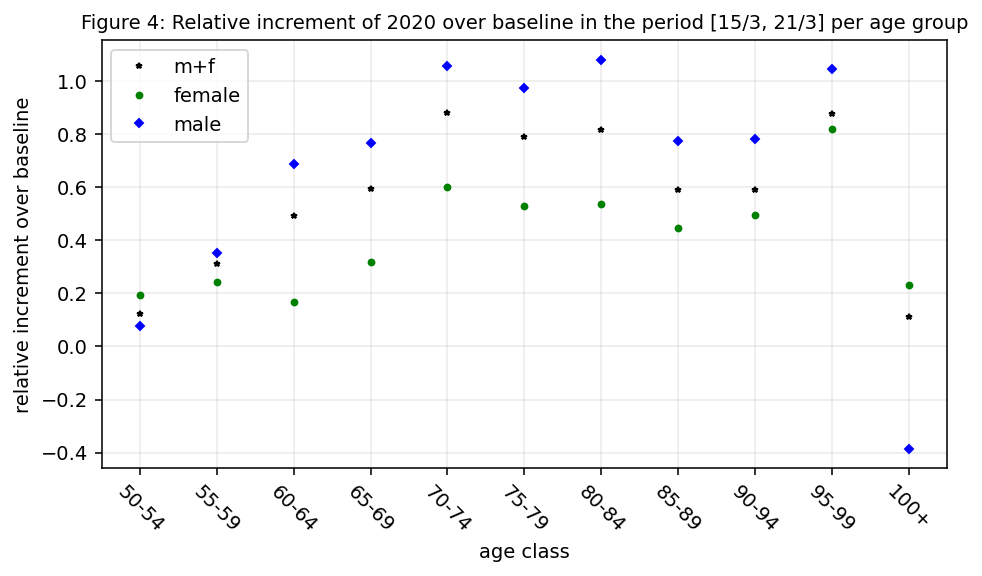

In [57]:
def func_formater(val, pos):
    try:        return FORMATTER[str(int(val))]
    except:     return ''

fig, ax = plot_one(ageofdeaths['t'], index = sages, one = 'rinc',
                   marker = '*', color = 'k', linestyle = 'None',
                   xrottick = -45, grid = 0.2,
                   xlabel = 'age class', ylabel = 'relative increment over baseline', label = 'm+f',
                   title = 'Figure 4: Relative increment of %s over baseline in the period [%s/%s, %s/%s] per age group' %
                        (YEAR, *get_daymonth(dstart), *get_daymonth(dend)),   
                   formatter = FuncFormatter(func_formater), locator = IndexLocator(base=1,offset=0)
                  )
ax.plot(ageofdeaths['f'].loc[sages,'rinc'],
        marker='o', color='g', markersize=3, linestyle='None', label='female'
       )

ax.plot(ageofdeaths['m'].loc[sages,'rinc'],
        marker='D', color='b', markersize=3, linestyle='None', label='male'
       )

ax.legend()

### Figure 5 - Empirical cumulative distribution of excess deaths in 15-21 March 2020 per age group<a id='Figure5'></a>

We compute the empirical cumulative distribution of excess deaths in 15-21 March 2020 per age group:

In [58]:
incdeaths = ageofdeaths['t'].apply(lambda row: row[YEAR] - row['base'], axis=1)
cumdeaths = incdeaths.cumsum(axis = 0, skipna =True)

then plotting the empirical cumulative distribution of excess deaths in the considered period:

(<Figure size 980x560 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x118c549d0>)

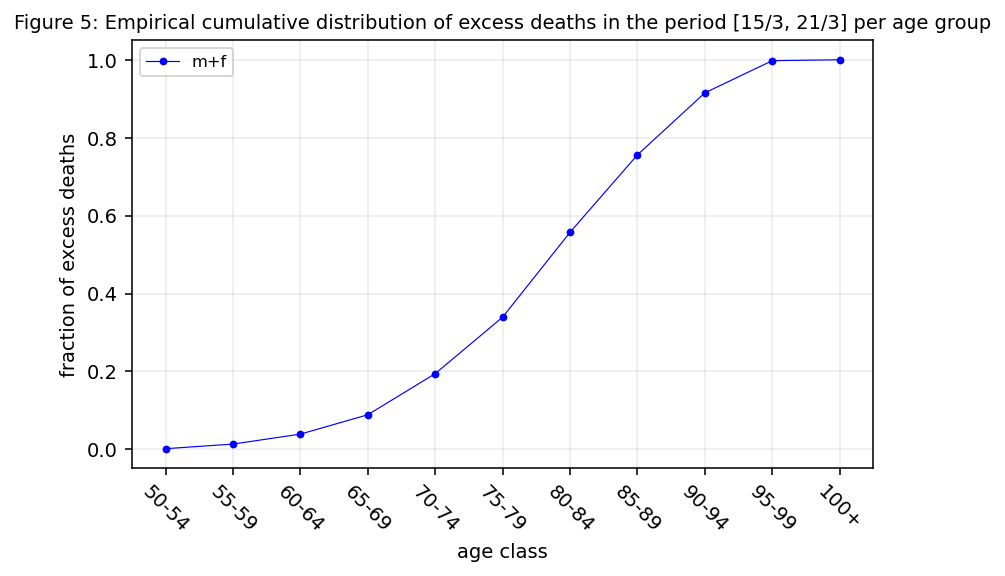

In [59]:
plot_one(cumdeaths/max(cumdeaths), index = sages, 
         marker = 'o', color = 'b', xrottick = -45, grid = 0.2,
         xlabel = 'age class',  ylabel = 'fraction of excess deaths', label = 'm+f',
         title = 'Figure 5: Empirical cumulative distribution of excess deaths in the period [%s/%s, %s/%s] per age group' % 
             (*get_daymonth(dstart), *get_daymonth(dend)), 
         formatter = FuncFormatter(func_formater), locator = IndexLocator(base=1,offset=0)
         )

### Figure 6 - Daily and cumulated deaths of males aged 65+<a id='Figure6'></a>

Given the age classes considered above (range of ages `rages`), we extrac the daily deaths for the male population (hence looking at "M_\*\*" field) over 65 similarly to what we have done for `dailydeaths`, just introducing a filter of the input data:

In [60]:
dailydeaths_m65 = pd.DataFrame()
for y in years:
    MCOL = dIT.meta.get('index')['m_%s' % str(y)[2:]]['name'] 
    dailydeaths_m65[y] = data[data[AGE].isin(rages)].groupby(DAY)[MCOL].agg('sum')
    if not calendar.isleap(y):
        yloc = dailydeaths_m65.columns.get_loc(y)
        dailydeaths_m65.iloc[ileapday,yloc] = dailydeaths_m65.iloc[ileapday-1,yloc]
dailydeaths_m65.set_index(dailydeaths_m65.index.to_series().apply(lambda ge: get_datetime(ge,YREF)), inplace=True)
dailydeaths_m65 = dailydeaths_m65.reindex(idx_timeline, fill_value=0) 

and then render the data:

(<Figure size 840x560 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11822c750>)

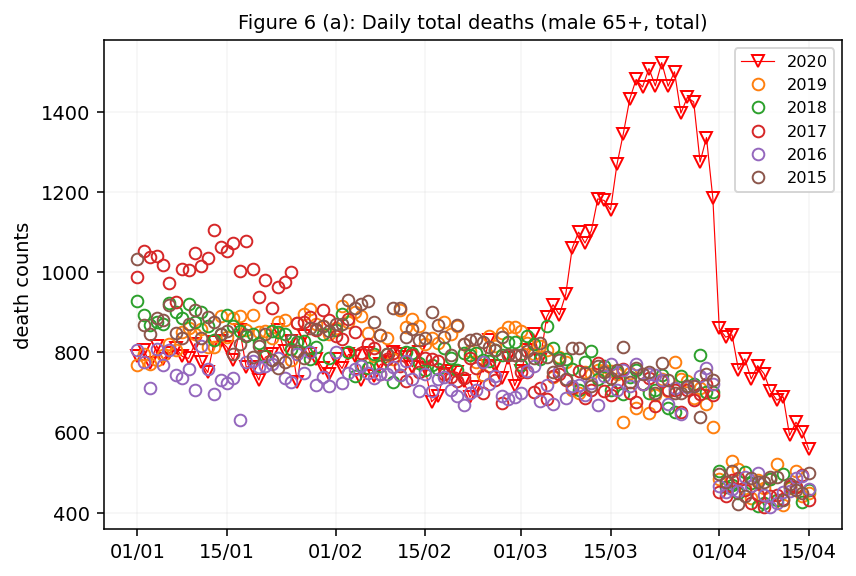

In [61]:
locator = mdates.DayLocator(bymonthday=[1,15]) # mdates.WeekdayLocator(interval=2)
formatter = mdates.DateFormatter('%d/%m')

plot_oneversus(dailydeaths_m65, one = YEAR, versus = years_exc[::-1], grid = 0.1, 
               ylabel='death counts', title = 'Figure 6 (a): Daily total deaths (male 65+, total)',            
               locator = locator, formatter = formatter
              )

Using `dailydeaths_m65`, it is then straightforward to compute and represent the cumulated deaths:

(<Figure size 840x560 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1182b3ed0>)

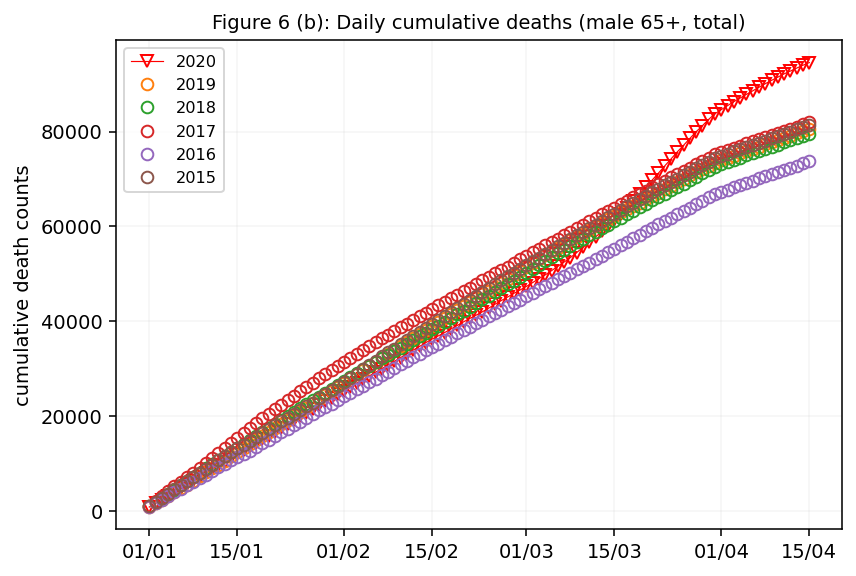

In [62]:
cumdailydeaths_m65 = dailydeaths_m65.cumsum(axis = 0)

plot_oneversus(cumdailydeaths_m65, one = YEAR, versus = years_exc[::-1], grid = 0.1,
               ylabel='cumulative death counts',
               title = 'Figure 6 (b): Daily cumulative deaths (male 65+, total)',
               locator = locator, formatter = formatter
              )

### Figure 7 - Total deaths in the period 1-21 March per individual municipalities<a id='Figure7'></a>

We introduce (now only) a new field in the original dataset in the form of a reference date (in the leap year `YREF`) as a way to handle the time series (where the year used in the index is actually irrelevant, only the day/month information is of use): 

In [63]:
dstart, dend = get_datetime('0301',YREF), get_datetime('0321',YREF)
data.insert(0, 'GE_DATE', data[DAY].apply(lambda row: get_datetime(row, YREF)))
data.head()

,GE_DATE,REG,PROV,NOME_REGIONE,NOME_PROVINCIA,NOME_COMUNE,COD_PROVCOM,TIPO_COMUNE,CL_ETA,GE,...,F_17,F_18,F_19,F_20,T_15,T_16,T_17,T_18,T_19,T_20
0,2000-02-28,1,1,Piemonte,Torino,Agliè,001001,1,9,0228,...,0,0,0,0,0,0,0,0,1,0
1,2000-01-13,1,1,Piemonte,Torino,Agliè,001001,1,10,0113,...,0,0,0,0,0,0,0,0,1,0
2,2000-03-05,1,1,Piemonte,Torino,Agliè,001001,1,11,0305,...,0,0,0,0,0,0,0,1,0,0
3,2000-02-04,1,1,Piemonte,Torino,Agliè,001001,1,12,0204,...,0,0,0,0,0,0,1,0,0,0
4,2000-03-02,1,1,Piemonte,Torino,Agliè,001001,1,12,0302,...,0,0,0,0,0,0,0,0,0,1


Because we look now at cities/municipalities individually, we will be examining the following fields:

In [64]:
CITY_CODE = dIT.meta.get('index')['city_code']['name']
print("- field of city/municipality codes: \033[94m%s\033[0m" % CITY_CODE)
PROV_CODE = dIT.meta.get('index')['prov_code']['name']
print("- field of province codes: \033[94m%s\033[0m" % PROV_CODE)
PROVINCE = dIT.meta.get('index')['province']['name']
print("- field of province names: \033[94m%s\033[0m" % PROVINCE)

- field of city/municipality codes: COD_PROVCOM
- field of province codes: PROV
- field of province names: NOME_PROVINCIA


Grouping by city/municipality enables us to actually estimate the sum of total deaths in the period considered (between `dstart` and `dend`). We also introduce the baseline figure for each city/municipality as the maximum number of deaths over the previous years':

In [65]:
citydeaths = pd.DataFrame()
for y in years:
    TCOL = dIT.meta.get('index')['t_%s' % str(y)[2:]]['name'] 
    citydeaths[y] = data[data['GE_DATE'].between(dstart, dend, inclusive=True)]   \
        .groupby(CITY_CODE)[TCOL].agg('sum')
citydeaths['base'] = citydeaths.loc[:,years_exc].max(axis=1)
citydeaths.head(5)

,2015,2016,2017,2018,2019,2020,base
COD_PROVCOM,,,,,,,
001001,1,3,1,3,3,7,3
001002,3,1,0,2,1,0,3
001003,0,0,0,0,0,1,0
001004,4,2,2,2,0,2,4
001006,2,1,2,3,2,3,3


It is easy to operate over all cities present in the dataset: 

In [66]:
cities = data.loc[:,[CITY, CITY_CODE, PROVINCE, PROV_CODE]].drop_duplicates()
# assert len(cities) == len(comuni) # remember: that was data[CITY].unique()
cities.head(10)

,NOME_COMUNE,COD_PROVCOM,NOME_PROVINCIA,PROV
0,Agliè,001001,Torino,1
88,Airasca,001002,Torino,1
148,Ala di Stura,001003,Torino,1
160,Albiano d'Ivrea,001004,Torino,1
212,Almese,001006,Torino,1
331,Alpette,001007,Torino,1
349,Alpignano,001008,Torino,1
701,Andezeno,001009,Torino,1
732,Andrate,001010,Torino,1
755,Angrogna,001011,Torino,1


but instead, we select, like in the study, only a bunch of them for annotation on the graph:

In [67]:
comuni = ['Albino', 'Bergamo', 'Brescia', 'Codogno', 'Crema', 
          'Milano', 'Nembro', 'Parma', 'Piacenza', 'San Giovanni Bianco']
comunitable = cities.loc[cities[CITY].isin(comuni)]
comunitable.set_index(comunitable[CITY_CODE], inplace=True)
comunitable

,NOME_COMUNE,COD_PROVCOM,NOME_PROVINCIA,PROV
COD_PROVCOM,,,,
015146,Milano,015146,Milano,15
016004,Albino,016004,Bergamo,16
016024,Bergamo,016024,Bergamo,16
016144,Nembro,016144,Bergamo,16
016188,San Giovanni Bianco,016188,Bergamo,16
017029,Brescia,017029,Brescia,17
019035,Crema,019035,Cremona,19
033032,Piacenza,033032,Piacenza,33
034027,Parma,034027,Parma,34


and we display everything together:

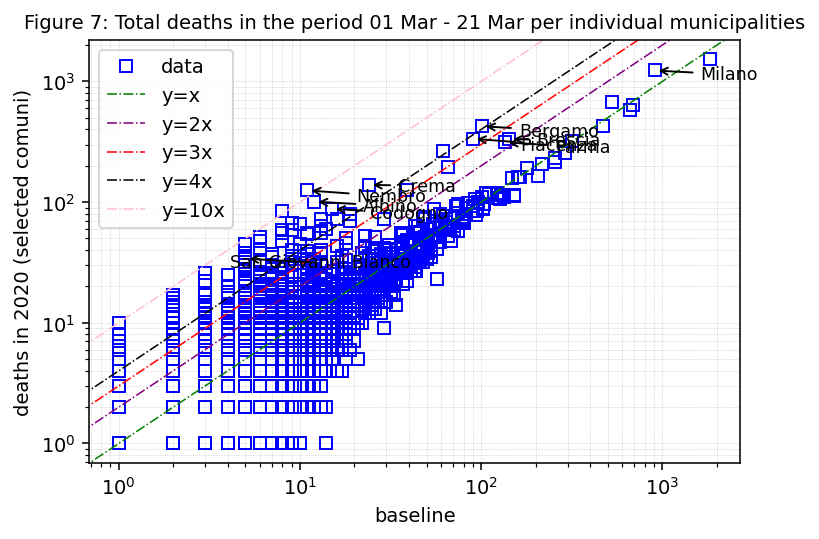

In [68]:
fig, ax = mplt.subplots(dpi=_DPI_)
citydeaths.plot(loglog=True,  x='base', y=YEAR, # kind='scatter',
                ls='None', color='b', marker='s', fillstyle='none', label='data', ax=ax
               )

xlim, ylim = ax.get_xlim(), ax.get_ylim()
x = np.arange(0, 10**4, 1)
for i, c in zip([1,2,3,4,10], ['g', 'purple', 'red', 'k', 'pink']):    
    ax.loglog(x, i * x, label = 'y=%sx' % ('' if i==1 else str(i)), ls='-.', lw=0.8, c=c)
ax.set_xlim(xlim), ax.set_ylim(ylim)
ax.grid(linewidth=0.3, which="both", ls='dotted')

for index in comunitable.index:
    xpos, ypos = citydeaths.loc[index,'base'], citydeaths.loc[index,YEAR]
    r = np.random.random() +1
    ax.annotate(comunitable.loc[index,CITY], 
                (xpos, ypos), 
                xytext=(xpos+r*10**np.log10(xpos), ypos-r*10**(np.log10(ypos)-1)),  
                arrowprops=dict(arrowstyle='->'), 
                size=9, ha='center')
    
ax.set_xlabel('baseline')
ax.set_ylabel('deaths in %s (selected comuni)' % YEAR)
ax.set_title('Figure 7: Total deaths in the period %s - %s per individual municipalities' % 
             (Datetime.datetime(dstart, fmt='%d %b'), Datetime.datetime(dend, fmt='%d %b')),  fontsize='medium'),
ax.legend()

We also propose to spatially represent the relative increment of deaths with respect to the baseline. Besides computing the actual increment, we also retrieve the `CITY_CODE` index (*i.e.* 'COD_PROVCOM') and insert it as a column that we rename 'PRO_COM_T': 

In [69]:
citydeaths['rinc'] = citydeaths[YEAR].sub(citydeaths.base).div(citydeaths.base)
citydeaths[PRO_COM_T] = citydeaths.index
citydeaths.head(5)

,2015,2016,2017,2018,2019,2020,base,rinc,PRO_COM_T
COD_PROVCOM,,,,,,,,,
001001,1,3,1,3,3,7,3,1.333333,001001
001002,3,1,0,2,1,0,3,-1.000000,001002
001003,0,0,0,0,0,1,0,inf,001003
001004,4,2,2,2,0,2,4,-0.500000,001004
001006,2,1,2,3,2,3,3,0.000000,001006


The 'PRO_COM_T' variable is actually used to 'left join' (`merge`) the `citydeaths` data together with the geographical data `geodata` on city vectorial representation:

In [70]:
geodata = geodata.merge(citydeaths, on=PRO_COM_T)
geodata.head(5)

,COD_RIP,COD_REG,COD_PROV,COD_CM,COD_UTS,PRO_COM,PRO_COM_T,COMUNE,COMUNE_A,CC_UTS,...,SHAPE_LEN,geometry,2015,2016,2017,2018,2019,2020,base,rinc
0,1,1,1,201,201,1077,001077,Chiaverano,None,0,...,18164.236621,"POLYGON ((414358.390 5042001.044, 414381.796 5...",1,2,1,2,2,1,2,-0.500000
1,1,1,1,201,201,1089,001089,Coazze,None,0,...,41591.122092,"POLYGON ((364914.897 4993224.894, 364929.991 4...",6,1,0,3,1,3,6,-0.500000
2,1,1,1,201,201,1006,001006,Almese,None,0,...,17058.439037,"POLYGON ((376934.962 4999073.854, 376960.555 4...",2,1,2,3,2,3,3,0.000000
3,1,1,1,201,201,1007,001007,Alpette,None,0,...,9795.562269,"POLYGON ((388890.737 5030465.123, 388945.987 5...",0,2,0,2,0,0,2,-1.000000
4,1,1,1,201,201,1039,001039,Brusasco,None,0,...,22957.401170,"POLYGON ((425639.220 5003889.831, 425691.001 5...",2,1,2,1,3,2,3,-0.333333


and we can represent it here:

/Library/miniconda3/lib/python3.7/site-packages/matplotlib/colors.py:1026: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)


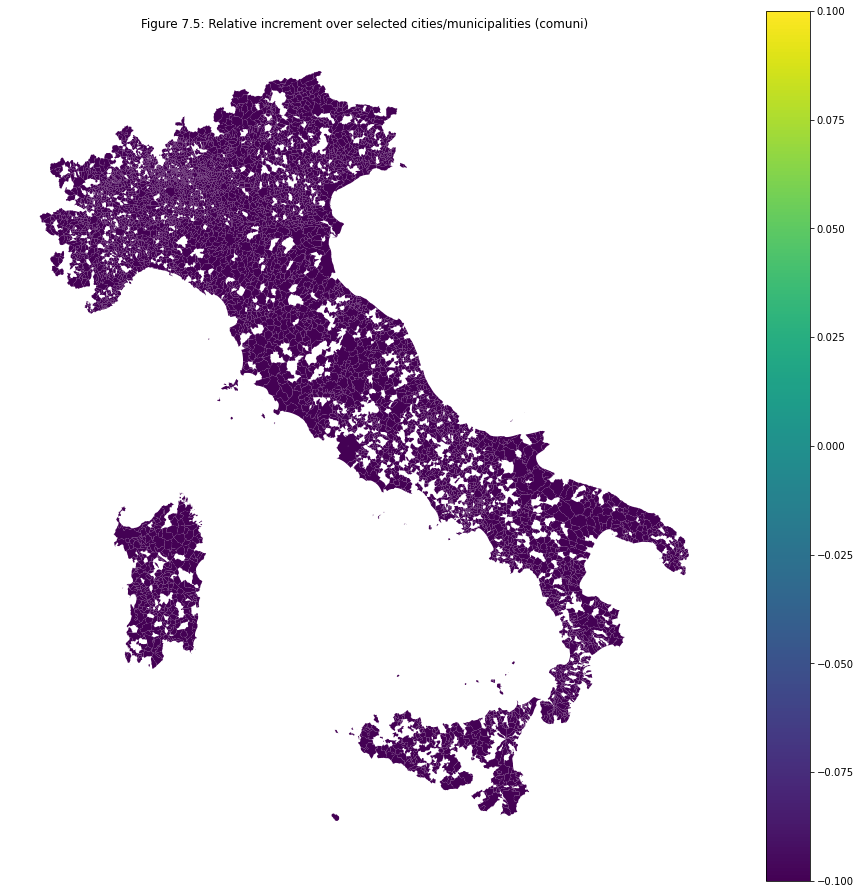

In [71]:
f, ax = mplt.subplots(1, figsize=(16, 16))
geodata.plot(column='rinc', legend=True, ax=ax)
ax.set_axis_off()
ax.set_title('Figure 7.5: Relative increment over selected cities/municipalities (comuni)')
mplt.show()

### Figures 8 - 12: Daily and cumulative deaths over individual cities<a id='Figure8'></a>

Let's pick a city among those analysed in the study:

In [72]:
fign = {'Codogno':8, 'Nembro':9, 'Orzinuovi':10, 'Brescia':11, 'Bergamo':12
       }
comune = 'Codogno' # 'Nembro' # 'Orzinuovi' # 'Brescia' # 'Bergamo'
comune_code = cities.loc[cities[CITY]==comune].loc[:,CITY_CODE].values.tolist()[0]
provincia = cities.loc[cities[CITY]==comune].loc[:,PROVINCE].values.tolist()[0]
print("Analysing the 'comune di' \033[1m%s\033[0m in 'provincia di' \033[1m%s\033[0m (#\033[1m%s\033[0m)" 
      % (comune,provincia,int(comune_code)))

Analysing the 'comune di' Codogno in 'provincia di' Lodi (#98019)


Grouping by date (`DAY`, *i.e.* 'GE') the data over the `comune` and aggregating the totals for the different years is what we need:

In [73]:
TCOLS = [dIT.meta.get('index')['t_%s' % str(y)[2:]]['name']
         for y in years]
dailydeaths = data[data[CITY]==comune].groupby(DAY).agg({t:'sum' for t in TCOLS})                  

dailydeaths.set_index(pd.Index(dailydeaths.index.to_series().apply(lambda ge: get_datetime(ge,YREF))), 
                      inplace=True)
dailydeaths.sort_index(inplace=True)
dailydeaths = dailydeaths.reindex(idx_timeline, method='pad').rename(columns={t:int('20%s' %t[-2:]) for t in TCOLS})

Let's display the total daily deaths for the selected city:

(<Figure size 840x560 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1183243d0>)

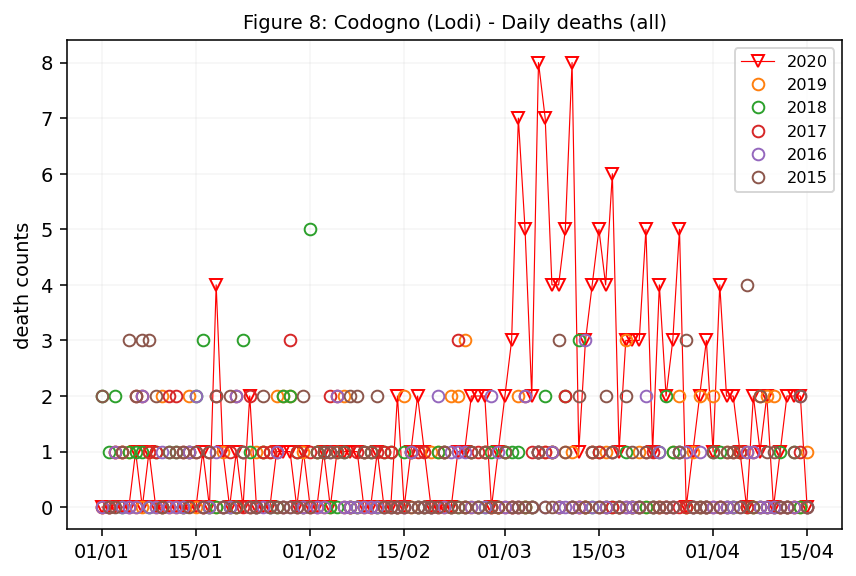

In [74]:
locator = mdates.DayLocator(bymonthday=[1,15]) # mdates.WeekdayLocator(interval=2)
formatter = mdates.DateFormatter('%d/%m')

plot_oneversus(dailydeaths, one = YEAR, versus = years_exc[::-1],
               ylabel='death counts', grid=0.1,
               title = 'Figure %s: %s (%s) - Daily deaths (all)' % (fign[comune],comune,provincia), 
               locator = locator, formatter = formatter
              )

as well as the cumulative deaths:

(<Figure size 840x560 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x118558490>)

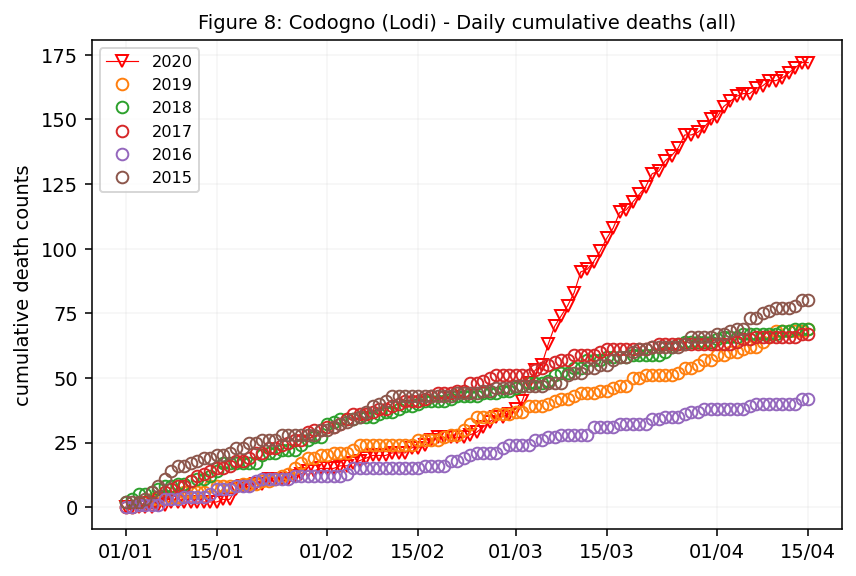

In [75]:
cumdailydeaths = dailydeaths.cumsum(axis = 0)

plot_oneversus(cumdailydeaths, one = YEAR, versus = years_exc[::-1],
               ylabel='cumulative death counts', grid=0.1,
               title = 'Figure %s: %s (%s) - Daily cumulative deaths (all)' % (fign[comune],comune,provincia), 
               locator = locator, formatter = formatter
              )

Similarly, we can process the data regarding the male population of 65y.o. and over in Codogno:

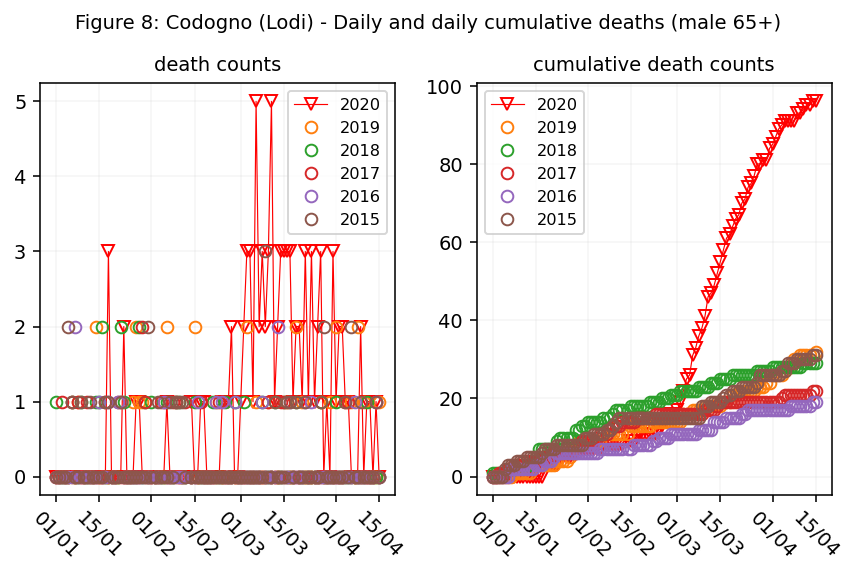

In [76]:
MCOLS = [dIT.meta.get('index')['m_%s' % str(y)[2:]]['name'] for y in years]

dailydeaths_m65 = data[(data[CITY]==comune) & (data[AGE].isin(rages))].groupby(DAY).agg({t:'sum' for t in MCOLS})                  
dailydeaths_m65.set_index(pd.Index(dailydeaths_m65.index.to_series().apply(lambda ge: get_datetime(ge,YREF))), 
                          inplace=True)
dailydeaths_m65.sort_index(inplace=True)
dailydeaths_m65 = dailydeaths_m65.reindex(idx_timeline).rename(columns={m:int('20%s' % m[-2:]) for m in MCOLS})

cumdailydeaths_m65 = dailydeaths_m65.cumsum(axis = 0)

fig, ax = plot_oneversus(dailydeaths_m65, one = YEAR, versus = years_exc[::-1], shp = (1,2),
                         title='death counts', grid=0.1, xrottick = -45, 
                         locator = locator, formatter = formatter
                        )

plot_oneversus(cumdailydeaths_m65, one = YEAR, versus = years_exc[::-1], fig = fig, ax=ax[1],
               title='cumulative death counts', grid=0.1, xrottick = -45, 
               suptitle = 'Figure %s: %s (%s) - Daily and daily cumulative deaths (male 65+)' 
                   % (fign[comune],comune,provincia), 
               locator = locator, formatter = formatter
              )

### Figure 13 - Total deaths in the week 15-21 March by groups of municipalities within the same province<a id='Figure13'></a>

We look at statistics for groups of municipalities and consider the following timeline and 'province' entities:

In [77]:
dstart, dend = get_datetime('0315',YREF), get_datetime('0321',YREF)

provinces = data.loc[:,[PROVINCE, PROV_CODE]].drop_duplicates()
print("Number of provinces represented in the dataset: \033[1m%s\033[0m" % len(provinces))
provinces.head(10)

Number of provinces represented in the dataset: 107


,NOME_PROVINCIA,PROV
0,Torino,1
29222,Vercelli,2
33732,Novara,3
40802,Cuneo,4
54084,Asti,5
59243,Alessandria,6
69855,Valle d'Aosta/Vallée d'Aoste,7
72681,Imperia,8
77343,Savona,9
83904,Genova,10


Similarly to the analysis run for Figure 7, we analyse total death counts for different groups of municipalities within the same province. However, the baseline this time will be the average death count for the previous years instead of the max: 

In [78]:
provdeaths = pd.DataFrame()
for y in years:
    TCOL = dIT.meta.get('index')['t_%s' % str(y)[2:]]['name'] 
    provdeaths[y] = data[data['GE_DATE'].between(dstart, dend, inclusive=True)]   \
        .groupby(PROV_CODE)[TCOL].agg('sum')
provdeaths['base'] = provdeaths.loc[:,years_exc].mean(axis=1)
#assert len(provinces) == len(provdeaths)
provdeaths.head(5)

,2015,2016,2017,2018,2019,2020,base
PROV,,,,,,,
1,449,489,478,485,475,585,475.2
2,39,50,51,44,49,100,46.6
3,75,75,84,61,89,153,76.8
4,115,133,113,124,132,163,123.4
5,53,69,53,59,51,65,57.0


Actually, we will keep only those provinces that registered 10+ death events over the considered period in 2020:

In [79]:
provdeaths.drop(provdeaths[provdeaths[YEAR]<10].index, inplace=True)
print("Number of provinces that recorded 10+ deaths during the considered period: \033[1m%s\033[0m" 
      % len(provdeaths))
provdeaths.head(5)

Number of provinces that recorded 10+ deaths during the considered period: 106


,2015,2016,2017,2018,2019,2020,base
PROV,,,,,,,
1,449,489,478,485,475,585,475.2
2,39,50,51,44,49,100,46.6
3,75,75,84,61,89,153,76.8
4,115,133,113,124,132,163,123.4
5,53,69,53,59,51,65,57.0


In [80]:
province = ['Piacenza', 'Cremona', 'Brescia', 'Bergamo', 'Milano']
provtable = provinces.loc[provinces[PROVINCE].isin(province)]
provtable.set_index(provtable[PROV_CODE], inplace=True)
provtable

,NOME_PROVINCIA,PROV
PROV,,
15,Milano,15
16,Bergamo,16
17,Brescia,17
19,Cremona,19
33,Piacenza,33


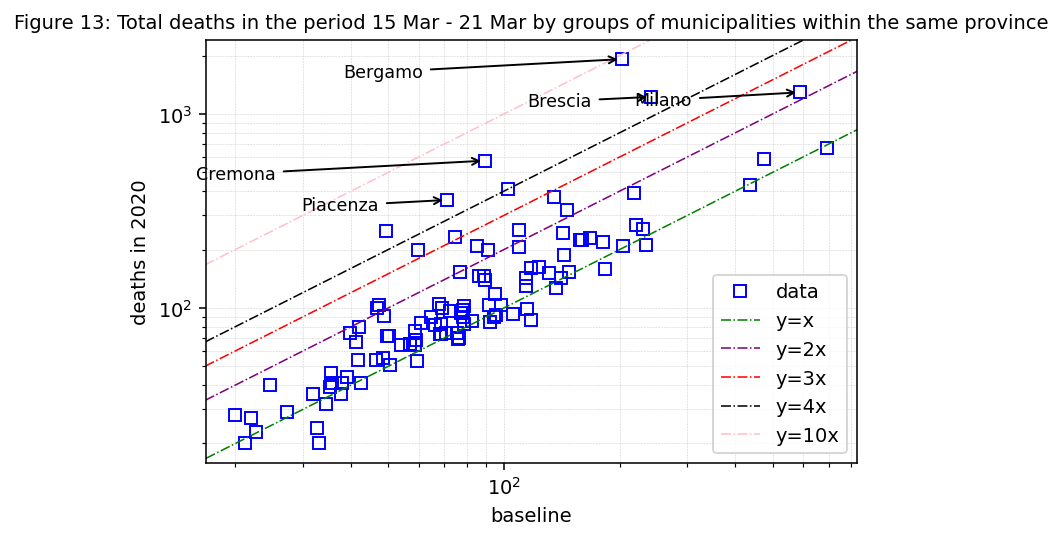

In [81]:
fig, ax = mplt.subplots(dpi=_DPI_)
provdeaths.plot(loglog=True,  x='base', y=YEAR, # kind='scatter',
                ls='None', color='b', marker='s', fillstyle='none', label='data', ax=ax
               )

xlim, ylim = ax.get_xlim(), ax.get_ylim()
x = np.arange(0, 10**4, 1)
for i, c in zip([1,2,3,4,10], ['g', 'purple', 'red', 'k', 'pink']):    
    ax.loglog(x, i * x, label = 'y=%sx' % ('' if i==1 else str(i)), ls='-.', lw=0.8, c=c
             )
ax.set_xlim(xlim), ax.set_ylim(ylim)
ax.grid(linewidth=0.3, which="both", ls='dotted')

for index in provtable.index:
    xpos, ypos = provdeaths.loc[index,'base'], provdeaths.loc[index,YEAR]
    r = np.random.random() +1
    ax.annotate(provtable.loc[index,PROVINCE], 
                (xpos, ypos), 
                xytext=(xpos-r*10**(np.log10(xpos)-0.4), ypos-r*10**(np.log10(ypos)-1)),  
                arrowprops=dict(arrowstyle='->'), 
                size=9, ha='center')
    
ax.set_xlabel('baseline')
ax.set_ylabel('deaths in %s' % YEAR)
ax.set_title('Figure 13: Total deaths in the period %s - %s by groups of municipalities within the same province' % 
             (Datetime.datetime(dstart, fmt='%d %b'), Datetime.datetime(dend, fmt='%d %b')),  fontsize='medium'),
ax.legend()

### Figures 14 - 16: Daily and cumulative deaths over individual provinces<a id='Figure14'></a>

As we did for figures 8-12, we select this time a province represented in the dataset:

In [82]:
fign = {'Bergamo':14, 'Lodi':15, 'Parma':16}
provincia = 'Bergamo' # 'Lodi' # 'Parma' 
provincia_code = cities.loc[cities[PROVINCE]==provincia].loc[:,PROV_CODE].values.tolist()[0]
print("Analysing the 'provincia di' \033[1m%s\033[0m (#\033[1m%s\033[0m)" 
      % (provincia,int(provincia_code)))

Analysing the 'provincia di' Bergamo (#16)


and we run a similar 'analysis' to actually report the total daily death counts and daily cumulative death counts:

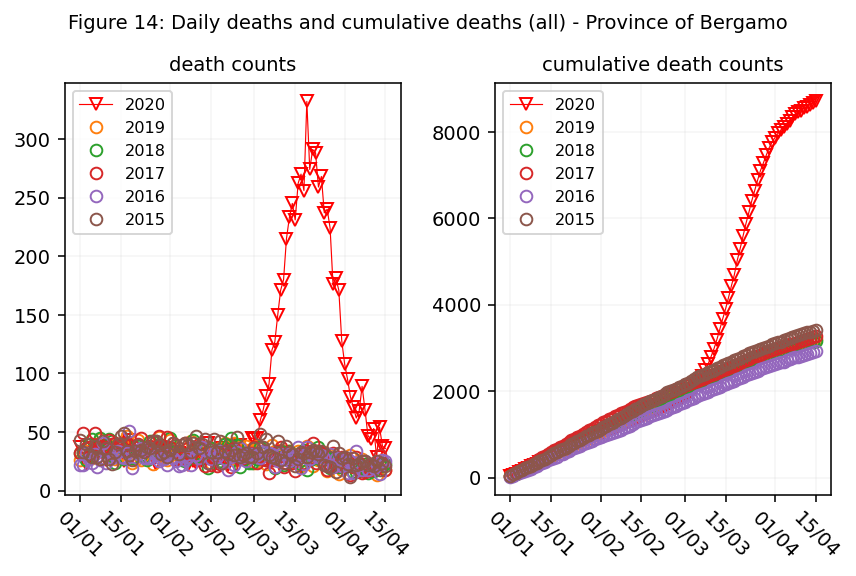

In [83]:
dailydeaths = pd.DataFrame()
for y in years:
    TCOL = dIT.meta.get('index')['t_%s' % str(y)[2:]]['name'] 
    dailydeaths[y] = data[data[PROV_CODE]==provincia_code].groupby(DAY)[TCOL].agg('sum')
    if not calendar.isleap(y):
        yloc = dailydeaths.columns.get_loc(y)
        dailydeaths.iloc[ileapday,yloc] = dailydeaths.iloc[ileapday-1,yloc]
dailydeaths.set_index(dailydeaths.index.to_series().apply(lambda ge: get_datetime(ge,YREF)), inplace=True)
dailydeaths = dailydeaths.reindex(idx_timeline, fill_value=0)       

cumdailydeaths = dailydeaths.cumsum(axis = 0)

locator, formatter = mdates.DayLocator(bymonthday=[1,15]), mdates.DateFormatter('%d/%m')

fig, ax = plot_oneversus(dailydeaths, one = YEAR, versus = years_exc[::-1], shp = (1,2),
                         title='death counts', grid=0.1, xrottick = -45,
                         locator = locator, formatter = formatter
                        )

plot_oneversus(cumdailydeaths, one = YEAR, versus = years_exc[::-1], fig = fig, ax=ax[1],
               title='cumulative death counts', grid=0.1, xrottick = -45,
               suptitle = 'Figure %s: Daily deaths and cumulative deaths (all) - Province of %s'
                   % (fign[provincia],provincia),
               locator = locator, formatter = formatter
              )

*ibid* for total daily death counts and daily cumulative death counts when considering the male population of 65 y.o. and over:

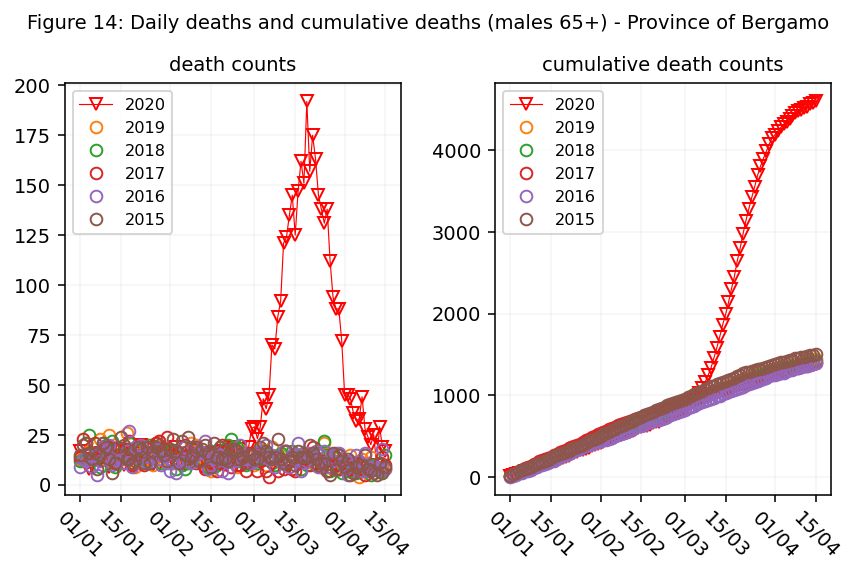

In [84]:
dailydeaths_m65 = pd.DataFrame()
for y in years:
    MCOL = dIT.meta.get('index')['m_%s' % str(y)[2:]]['name'] 
    dailydeaths_m65[y] = data[(data[PROV_CODE]==provincia_code) & (data[AGE].isin(rages))].groupby(DAY)[MCOL].agg('sum')
    if not calendar.isleap(y):
        yloc = dailydeaths_m65.columns.get_loc(y)
        dailydeaths_m65.iloc[ileapday,yloc] = dailydeaths_m65.iloc[ileapday-1,yloc]
dailydeaths_m65.set_index(dailydeaths_m65.index.to_series().apply(lambda ge: get_datetime(ge,YREF)), inplace=True)
dailydeaths_m65 = dailydeaths_m65.reindex(idx_timeline, fill_value=0) 

cumdailydeaths_m65 = dailydeaths_m65.cumsum(axis = 0, skipna =True) # default

locator, formatter = mdates.DayLocator(bymonthday=[1,15]), mdates.DateFormatter('%d/%m')

fig, ax = plot_oneversus(dailydeaths_m65, one = YEAR, versus = years_exc[::-1], shp = (1,2),
            title='death counts', grid=0.1, xrottick = -45,
            locator = locator, formatter = formatter)

plot_oneversus(cumdailydeaths_m65, one = YEAR, versus = years_exc[::-1], fig = fig, ax=ax[1],
            title='cumulative death counts', grid=0.1, xrottick = -45,
            suptitle = 'Figure %s: Daily deaths and cumulative deaths (males 65+) - Province of %s' 
               % (fign[provincia],provincia),
            locator = locator, formatter = formatter)